In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change directory to shared folder
import os
shared_folder = "/content/drive/MyDrive/DSCI 550: Team Folder/Assignment1_files"
os.chdir(shared_folder)

# List files in the shared folder
os.listdir()

# Loading Raw Dataset File

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re

# Download the necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')

# Load the CSV file
df = pd.read_csv('haunted_places.csv')
print('DataFrame created from : haunted_places.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


FileNotFoundError: [Errno 2] No such file or directory: 'haunted_places.csv'

# Data Cleaning
The haunted_places.csv contains unstructured description text.
Cleaning strings of tokenized words (removing punctuations and capitalizations)

In [ ]:
def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove all punctuation and non-alphanumeric characters, keep only words
    tokens = [word for word in tokens if word.isalnum()]
    # Join tokens into a single space-separated string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply the function to each cell in the DataFrame
df['clean_description'] = df['description'].apply(clean_text)

# Download results
df.to_csv('cleaned_haunted_file.csv', index=False)

df.clean_description.head()

,clean_description
0,Ada witch Sometimes you can see a misty blue f...
1,A little girl was killed suddenly while waitin...
2,If you take Gorman Rd west towards Sand Creek ...
3,In the 1970 one room room 211 in the old secti...
4,Kappa Delta Sorority The Kappa Delta Sorority ...


In [ ]:
def clean_misspellings(df, column, corrections: dict):
    for misspelling, correct in corrections.items():
        df[column] = df[column].str.replace(fr'\b{misspelling}\b', correct, regex=True)
        df[column] = df[column].str.replace(fr'\b{misspelling}s\b', correct + 's', regex=True)
    df['clean_spelling'] = df[column]
    return df

In [ ]:
# Dictionary of misspellings - {Misspelled word: Correct word}, simple 's' pluralization is accounted for.
corrections = {'sprit': 'spirit',
               'gost': 'ghost',
               'aparition': 'apparition', 'apperition': 'apparition',
               'poltergiest': 'poltergeist',
               'figer': 'figure'}

# Apply function
df = clean_misspellings(df, 'clean_description', corrections)
print("df['clean_spelling'] created")
# Download results
#df.to_csv('cleaned_spelling_haunted_file.csv', index=False)
#print('Downloaded cleaned_spelling_haunted_file.csv')

df['clean_spelling'] created


Function to search specified misspelled words and replace them with the correct word.

# Featurization (LLM)

## LLM (Audio Evidence)

In [ ]:
import openai
import pandas as pd
from tqdm import tqdm
import re

# initialize OpenAI client
client = openai.OpenAI(api_key="Key-HERE")

df_raw = pd.read_csv('haunted_places.csv')


# select a random sample
# df_sample = df.sample(n=20, random_state=25).copy()

def extract_audio_evidence(description):
    prompt = f"""
    You are analyzing descriptions of haunted locations to determine if they contain **audio evidence** of paranormal activity.

    - Only consider sounds that are **explicitly linked to a supernatural presence**, such as **unexplained whispers, ghostly voices, eerie sounds, disembodied footsteps, supernatural noises, or loud bangs with no source**.
    - Ignore background noises like **wind, animals, creaking houses, traffic, or other natural/environmental sounds** unless connected to the paranormal event.

    ### **Task**
    Analyze the following description and determine **if it contains audio evidence of paranormal activity**. Your answer must be in the format:

    **Answer:** Yes or No
    **Reasoning:** [Brief explanation of why audio evidence is or is not present]

    ### **Example 1 (Audio Evidence Present)**
    **Description:**
    _"Visitors often hear whispers echoing through the empty halls at night. Some claim to hear their names being called when no one is there."_

    **Expected Response:**
    **Answer:** Yes
    **Reasoning:** The description explicitly mentions unexplained whispers and voices, which are directly tied to paranormal activity.

    ---
    ### **Example 2 (No Audio Evidence)**
    **Description:**
    _"A woman in a white dress has been spotted near the graveyard, standing motionless under the moonlight."_

    **Expected Response:**
    **Answer:** No
    **Reasoning:** There is no mention of sound-related experiences in this description.
    ---
    ### **Now analyze this description:**
    {description}
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=100,
            temperature=0.1
        )

        # obtain response(this was for testing)
        content = response.choices[0].message.content.strip()
        # print("RAW RESPONSE:", content)

        # get yes/no answer
        answer_match = re.search(r"\*\*Answer:\*\*\s*(Yes|No)", content, re.IGNORECASE)
        reasoning_match = re.search(r"\*\*Reasoning:\*\*\s*(.*)", content, re.DOTALL)

        answer = answer_match.group(1) if answer_match else "Not Found"
        reasoning = reasoning_match.group(1).strip() if reasoning_match else "Not Found"

        # binary answer
        return pd.Series([answer, reasoning])

    except Exception as e:
        return pd.Series([f"Error: {str(e)}", ""])

# apply to 2 columns
tqdm.pandas()
df[["Audio Evidence", "Reasoning"]] = df["description"].progress_apply(extract_audio_evidence)

# save
df.to_csv("haunted_places_sample_audio.csv", index=False)

KeyboardInterrupt: 

Read the csv input (haunted_places_sample_audio.csv) of the Audio Evidence LLM output.
Then append those columns to the main df

In [ ]:
df_audio = pd.read_csv("haunted_places_sample_audio.csv", sep=",")
df_audio.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,Audio Evidence,Reasoning
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,Yes,The description includes reports of hearing th...
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,Yes,The description includes instances of knocking...
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,No,The description does not mention any specific ...
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,No,The description details various phenomena such...
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,Yes,The description includes reports of giggling a...


In [ ]:
df = df.join(df_audio[['Audio Evidence', 'Reasoning']])
df.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,clean_description,clean_spelling,Audio Evidence,Reasoning
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,Ada witch Sometimes you can see a misty blue f...,Ada witch Sometimes you can see a misty blue f...,Yes,The description includes reports of hearing th...
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,A little girl was killed suddenly while waitin...,A little girl was killed suddenly while waitin...,Yes,The description includes instances of knocking...
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,If you take Gorman Rd west towards Sand Creek ...,If you take Gorman Rd west towards Sand Creek ...,No,The description does not mention any specific ...
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,In the 1970 one room room 211 in the old secti...,In the 1970 one room room 211 in the old secti...,No,The description details various phenomena such...
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,Kappa Delta Sorority The Kappa Delta Sorority ...,Kappa Delta Sorority The Kappa Delta Sorority ...,Yes,The description includes reports of giggling a...


In [ ]:
df.rename(columns={'Reasoning': 'Audio Reasoning'}, inplace=True)
print(df.columns)

Index(['city', 'country', 'description', 'location', 'state', 'state_abbrev',
       'longitude', 'latitude', 'city_longitude', 'city_latitude',
       'clean_description', 'clean_spelling', 'Audio Evidence',
       'Audio Reasoning'],
      dtype='object')


In [ ]:
print(df.columns)

Index(['city', 'country', 'description', 'location', 'state', 'state_abbrev',
       'longitude', 'latitude', 'city_longitude', 'city_latitude',
       'clean_description', 'clean_spelling', 'Audio Evidence',
       'Audio Reasoning'],
      dtype='object')


## Time of Day

**Time of day evidence code**

In [ ]:
##uncomment this to install the keras tensorflow
## pip install tensorflow
# pip install tf-keras

## This feature approach return the time of the day label using zero-shot classification
## of the zero=shot classification from facebool/bart-large-mnli


import pandas as pd
from transformers import pipeline

# Initialize the NLI pipeline using a pre-trained model from Hugging Face
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Function to classify time of day using NLI
def classify_time_of_day(text):
    # Define the possible labels (morning, evening, dusk, unknown)
    candidate_labels = ["Morning", "Evening", "Dusk", "Unknown"]

    # Use the zero-shot classification to classify the text
    result = classifier(text, candidate_labels)

    # Return the label with the highest score
    return result['labels'][0]

# Function to process the CSV and add the time of day column
def update_time_of_day(input_file):
    # Read the CSV file into a pandas DataFrame
    df_time_of_day = pd.read_csv(input_file)

    # Check if 'description' column exists
    if 'description' not in df.columns:
        print("Error: The CSV file must contain a 'description' column with text data.")
        return

    # Create a list to hold the time of day results
    time_of_day_list = []

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        text = row['description']  # Get the text data from the 'description' column

        # Use the NLI classifier to determine the time of day
        time_of_day = classify_time_of_day(text)
        time_of_day_list.append(time_of_day)

    # Add the 'time_of_day' column to the DataFrame
    df_time_of_day['time_of_day'] = time_of_day_list

    # Save the updated DataFrame to a new CSV file
    df.to_csv('time_of_day_file.csv', index=False)
    print("Updated file saved as 'time_of_day_file.csv'.")

# Example usage: Pass your CSV file path as an argument
update_time_of_day('cleaned_haunted_file.csv')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
df_time_of_day = pd.read_csv("updated_time_of_day_file.csv", sep=",")
df_time_of_day.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,time_of_day
0,Ada,United States,Ada witch Sometimes you can see a misty blue f...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,Dusk
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,Dusk
2,Adrian,United States,If you take Gorman Rd west towards Sand Creek ...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,Evening
3,Adrian,United States,In the 1970 one room room 211 in the old secti...,Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,Unknown
4,Albion,United States,Kappa Delta Sorority The Kappa Delta Sorority ...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,Evening


In [ ]:
df = df.join(df_time_of_day[['time_of_day']])
df.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,clean_description,clean_spelling,Audio Evidence,Audio Reasoning,time_of_day
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,Ada witch Sometimes you can see a misty blue f...,Ada witch Sometimes you can see a misty blue f...,Yes,The description includes reports of hearing th...,Dusk
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,A little girl was killed suddenly while waitin...,A little girl was killed suddenly while waitin...,Yes,The description includes instances of knocking...,Dusk
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,If you take Gorman Rd west towards Sand Creek ...,If you take Gorman Rd west towards Sand Creek ...,No,The description does not mention any specific ...,Evening
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,In the 1970 one room room 211 in the old secti...,In the 1970 one room room 211 in the old secti...,No,The description details various phenomena such...,Unknown
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,Kappa Delta Sorority The Kappa Delta Sorority ...,Kappa Delta Sorority The Kappa Delta Sorority ...,Yes,The description includes reports of giggling a...,Evening


## **Image/Video/Visual Evidence**


In [ ]:

import openai
import pandas as pd
from tqdm import tqdm
import os
import re


# initialize OpenAI client
client = openai.OpenAI(api_key="API KEY")

# Normalize column names (remove spaces, convert to lowercase)
df.columns = df.columns.str.lower().str.strip()

# Check if "description" column exists
if "description" not in df.columns:
    raise KeyError("The column 'description' is missing from the dataset. Check your CSV file.")

# Define function to extract visual evidence
def extract_visual_evidence(description):
    prompt = f"""
    Does the following text specifically mention existing images, videos, or photographic evidence of paranormal activity?
    Only count it as 'Yes' if the text explicitly states that a photo, video, or recorded footage exists.
    Include security camera footage only if it captured something unusual, but ignore mentions of security cameras in general or warnings about surveillance if it does not have to do with paranormal activity.
    Ignore any mentions of security guards recording trespassers, people seeing something with their own eyes, or unverified claims.
    Count news reports if they state a photo or video was included.
    Include historical or archival footage if it is still available.
    Include multiple witness reports if they claim to have recorded evidence.

    **Task:**
    Analyze the following description and determine if it contains visual evidence of paranormal activity.
    Your answer must be in the following format:

    **Answer:** Yes or No
    **Reasoning:** [Brief explanation of why visual evidence is or is not present]

    **Example 1 (Visual Evidence Present)**
    **Description:**
    _"Denton Rd. - There's an overall bad feeling in this cemetery. If you take a camera (preferably digital) and take pictures, you'll see orbs everywhere. There's a specific large, greenish orb that shows up in photographs quite a bit."_

    **Expected Response:**
    **Answer:** Yes
    **Reasoning:** The description explicitly mentions unexplained green orbs that are in photographs, which are directly tied to paranormal activity.

    **Example 2 (No Visual Evidence)**
    **Description:**
    _"People report hearing footsteps, and doors slamming where there are no doors, a small child's voice say 'Mama?'."_

    **Expected Response:**
    **Answer:** No
    **Reasoning:** There is no mention of visual-related experiences in this description.

    ---
    ### **Now analyze this description:**
    {description}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=100,
            temperature=0.1
        )

        # Obtain raw response
        content = response.choices[0].message.content.strip()
        # print("RAW RESPONSE:", content)  # Debugging

        # Improved regex parsing
        answer_match = re.search(r"(?i)\*\*Answer:\*\*\s*(True|False)", content)
        reasoning_match = re.search(r"(?i)\*\*Reasoning:\*\*\s*(.+)", content, re.DOTALL)

        answer = answer_match.group(1) if answer_match else "Unknown"
        reasoning = reasoning_match.group(1).strip() if reasoning_match else "Parsing error"

        return pd.Series([answer, reasoning])

    except Exception as e:
        return pd.Series([f"Error: {str(e)}", ""])

# Apply function to DataFrame with tqdm progress bar
tqdm.pandas()
df[["visual_evidence", "reasoning"]] = df["description"].progress_apply(extract_visual_evidence)

# Save results
df.to_csv("haunted_places_visual_evidence.csv", index=False)
print("Processing complete. File saved as 'cleaned_haunted_file.csv'.")

In [ ]:
df_visual_evidence = pd.read_csv("haunted_places_visual_evidence.csv", sep=",")
df_visual_evidence.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,visual_evidence,reasoning
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,False,The description does not mention any existing ...
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,False,The description details various paranormal act...
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,False,The description does not mention any existing ...
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,False,The description details various paranormal phe...
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,False,The description does not mention any existing ...


In [ ]:
df = df.join(df_visual_evidence[["visual_evidence", "reasoning"]])
df.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,clean_description,clean_spelling,Audio Evidence,Audio Reasoning,time_of_day,visual_evidence,reasoning
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,Ada witch Sometimes you can see a misty blue f...,Ada witch Sometimes you can see a misty blue f...,Yes,The description includes reports of hearing th...,Dusk,False,The description does not mention any existing ...
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,A little girl was killed suddenly while waitin...,A little girl was killed suddenly while waitin...,Yes,The description includes instances of knocking...,Dusk,False,The description details various paranormal act...
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,If you take Gorman Rd west towards Sand Creek ...,If you take Gorman Rd west towards Sand Creek ...,No,The description does not mention any specific ...,Evening,False,The description does not mention any existing ...
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,In the 1970 one room room 211 in the old secti...,In the 1970 one room room 211 in the old secti...,No,The description details various phenomena such...,Unknown,False,The description details various paranormal phe...
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,Kappa Delta Sorority The Kappa Delta Sorority ...,Kappa Delta Sorority The Kappa Delta Sorority ...,Yes,The description includes reports of giggling a...,Evening,False,The description does not mention any existing ...


In [ ]:
df.rename(columns={'visual_evidence': 'Visual Evidence', 'reasoning': 'Visual Reasoning'}, inplace=True)

In [ ]:
df.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,clean_description,clean_spelling,Audio Evidence,Audio Reasoning,time_of_day,visual_evidence,reasoning
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,Ada witch Sometimes you can see a misty blue f...,Ada witch Sometimes you can see a misty blue f...,Yes,The description includes reports of hearing th...,Dusk,False,The description does not mention any existing ...
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,A little girl was killed suddenly while waitin...,A little girl was killed suddenly while waitin...,Yes,The description includes instances of knocking...,Dusk,False,The description details various paranormal act...
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,If you take Gorman Rd west towards Sand Creek ...,If you take Gorman Rd west towards Sand Creek ...,No,The description does not mention any specific ...,Evening,False,The description does not mention any existing ...
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,In the 1970 one room room 211 in the old secti...,In the 1970 one room room 211 in the old secti...,No,The description details various phenomena such...,Unknown,False,The description details various paranormal phe...
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,Kappa Delta Sorority The Kappa Delta Sorority ...,Kappa Delta Sorority The Kappa Delta Sorority ...,Yes,The description includes reports of giggling a...,Evening,False,The description does not mention any existing ...


## Witness Count
Witness count parser + LLM extraction = ~30% 0's (As long as the scene was witness/seen by anyone, it should be counted; prior would exclude 1st person; included example as references, pattern box with REGEX)

Hybrid approach: Pre-process with library/REGEX -->
- Multiple and nuanced approach to testing/trial -> long delay in running operations

In [ ]:
import openai
import pandas as pd
from tqdm import tqdm
import re
from number_parser import parse

# initialize OpenAI client
client = openai.OpenAI(api_key="KEY-HERE")

# read in df
df_witness = pd.read_csv("df_with_img_feat.csv", sep=",")

# select a random sample for testing
# df_sample = df.sample(n=50, random_state=24).copy()


def extract_candidate_number(description):
    """
    uses regex patterns along with number-parser to extract a candidate  for the witness count.
    looks for the following phrases
    """
    patterns = [
        r"I saw ([A-Za-z0-9\-]+)",
        r"I experienced ([A-Za-z0-9\-]+)",
        r"I witnessed ([A-Za-z0-9\-]+)",
        r"(\w+)\s+visitors",
        r"(\w+)\s+onlookers",
        r"(\w+)\s+people",
        r"(\w+)\s+individuals",
        r"(\w+)\s+witnesses",
        r"(\w+)\s+bystanders",
        r"(\w+)\s+spectators",
        r"at least (\w+)",
        r"no less than (\w+)",
        r"around (\w+)",
        r"approximately (\w+)",
        r"witnessed by (\w+)"

    ]
    for pattern in patterns:
        match = re.search(pattern, description, re.IGNORECASE)
        if match:
            candidate_str = match.group(1)
            try:
                # Try direct integer conversion first.
                candidate_num = int(candidate_str)
            except ValueError:
                # If that fails, use number-parser to convert textual numbers.
                candidate_num = parse(candidate_str)
            if candidate_num is not None:
                return str(candidate_num)
    return "0"


def refine_witness_count(description, candidate):
    """
    uses the LLM to evaluate whether the candidate witness count is correct.
    if not, the model should output the corrected witness count and justification.
    """
    prompt = f"""
    You are an expert in sentiment analysis and contextual reading. We have automatically extracted a candidate witness count of "{candidate}" from the following description:

    {description}

    Based on the context, tone, and details provided, please evaluate whether this candidate accurately represents the number of witnesses to the paranormal event. If it is correct, confirm it and explain your reasoning. If it is not correct, please provide the corrected witness count and justify your answer.

    Please consider:
    - If the narrator explicitly states their own experience (e.g., "I saw", "I experienced", or "I witnessed") and no other witnesses are mentioned, count the narrator as one witness.
    - If the description clearly states or implies that multiple people witnessed the event, use that number.
    - Ignore numbers that refer to unrelated details (e.g., "5 bodies" or "3 floors").
    - If the description only provides a lower bound or a tentative figure (for example, using qualitative clues such as "some", "a couple", etc.), output the floor value and append a '+' sign (e.g., "2+") to indicate it may be higher.
    - Default to 0 if, after a thorough analysis, there is an indication that nobody witnessed the event. Use fair judgement, but do not go overboard stretching the text to find a non-existent witnesses.
    - If the event was witnessed or seen/experienced by someone, even if not specified by exactly who, they should count as a witness. ex.
      The Richardi House (now known as The Grand Victorian Bed & Breakfast) is rumored to be haunted by Henri Richardi. Richardi built the house for his intended bride. When she left him for another man, he was heartbroken. Strange lights were seen in the cupola when the house was uninhabited (before being turned into a Bed & Breakfast). This should yield at least one person as it claims the lights were "seen" even if we dont know by who.
    - Only provide numbers for count, do not give answers like. "many" or "a lot"

    Format your answer exactly as follows:

    **Correct Witness Count:** [number or number with a '+' if it's a floor estimate]
    **Reasoning:** [A brief explanation of your evaluation and how you arrived at the number]
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=100,
            temperature=0.1
        )
        content = response.choices[0].message.content.strip()
        # debugging output
        print("Refinement RAW RESPONSE:", content)

        # extract the witness count and reasoning from the LLM's response.
        witness_match = re.search(r"\*\*Correct Witness Count:\*\*\s*([A-Za-z0-9\s\+\-]+)", content, re.IGNORECASE)
        reasoning_match = re.search(r"\*\*Reasoning:\*\*\s*(.*)", content, re.DOTALL)
        witness_count_raw = witness_match.group(1).strip() if witness_match else candidate
        reasoning = reasoning_match.group(1).strip() if reasoning_match else "Not Found"

        # process the extracted witness count:
        if "plus" in witness_count_raw.lower() or '+' in witness_count_raw:
            number_match = re.search(r"(\d+)", witness_count_raw)
            if number_match:
                witness_count = number_match.group(1) + "+"
            else:
                witness_count = witness_count_raw
        else:
            try:
                witness_count = str(int(witness_count_raw))
            except ValueError:
                witness_count = "0"

        return pd.Series([witness_count, reasoning])
    except Exception as e:
        return pd.Series([f"Error: {str(e)}", ""])



def process_witness_count(description):
    candidate = extract_candidate_number(description)
    return refine_witness_count(description, candidate)


# apply function to sample
tqdm.pandas()
df[["Witness Count", "Witness Reasoning"]] = df_witness["description"].progress_apply(process_witness_count)

# save
df.to_csv("haunted_places_with_witness_Final.csv", index=False)




In [ ]:
df_witness = pd.read_csv("haunted_places_with_witness_Final.csv", sep=",")
df_witness.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,Audio Evidence,Reasoning,Undergrad_Grad_Rate,HS_Grad_Rate,STEM_Grad_Percentage,Witness Count,Witness Reasoning
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,Yes,The description includes reports of hearing th...,62.0%,84.1%,22.0%,3+,"The description mentions ""Some people have rep..."
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,Yes,The description includes instances of knocking...,62.0%,84.1%,22.0%,3+,The description mentions several instances of ...
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,No,The description does not mention any specific ...,62.0%,84.1%,22.0%,2+,The narrative describes a tragic event where t...
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,No,The description details various phenomena such...,62.0%,84.1%,22.0%,3+,"The text mentions ""several witnesses"" during a..."
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,Yes,The description includes reports of giggling a...,62.0%,84.1%,22.0%,2+,"The description mentions ""Current sisters ther..."


In [ ]:
df = df.join(df_witness[["Witness Count", "Witness Reasoning"]])
df.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,clean_description,clean_spelling,Audio Evidence,Audio Reasoning,time_of_day,visual_evidence,reasoning,Witness Count,Witness Reasoning
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,Ada witch Sometimes you can see a misty blue f...,Ada witch Sometimes you can see a misty blue f...,Yes,The description includes reports of hearing th...,Dusk,False,The description does not mention any existing ...,3+,"The description mentions ""Some people have rep..."
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,A little girl was killed suddenly while waitin...,A little girl was killed suddenly while waitin...,Yes,The description includes instances of knocking...,Dusk,False,The description details various paranormal act...,3+,The description mentions several instances of ...
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,If you take Gorman Rd west towards Sand Creek ...,If you take Gorman Rd west towards Sand Creek ...,No,The description does not mention any specific ...,Evening,False,The description does not mention any existing ...,2+,The narrative describes a tragic event where t...
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,In the 1970 one room room 211 in the old secti...,In the 1970 one room room 211 in the old secti...,No,The description details various phenomena such...,Unknown,False,The description details various paranormal phe...,3+,"The text mentions ""several witnesses"" during a..."
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,Kappa Delta Sorority The Kappa Delta Sorority ...,Kappa Delta Sorority The Kappa Delta Sorority ...,Yes,The description includes reports of giggling a...,Evening,False,The description does not mention any existing ...,2+,"The description mentions ""Current sisters ther..."


# Featurization (Keyword Matching & Word Vectorization)

## Helper Tools
Helper tool to look for a specific keyword within a dataframe column.
Capitalization doesn't matter. Spelling and characters do matter.

In [ ]:
def search_words_in_column(df, column, words: list):
    results = []
    total_counts = {word: 0 for word in words}
    rows_found = {word: 0 for word in words}

    for index, row in df.iterrows():
        text = row[column].lower()

        row_counts = {word: text.split().count(word.lower()) for word in words}  # Count each word

        for word, count in row_counts.items():
            if count > 0:
                results.append({'Row Index': index, 'Word': word, 'Count': count, 'Text': row[column]})
                total_counts[word] += count
                rows_found[word] += 1

    for word in words:
        if total_counts[word] > 0:
          print(f"The word '{word}' was found {total_counts[word]} times in {rows_found[word]} rows.")
        else:
          continue

    return results

potential_misspelled_words = [
    "gost", "ghots", "gohst", "ghst",  # ghost
    "sprit", "spirrit", "spiret", "spirut",  # spirit
    "appirition", "apparitian", "appariton", "aparition", "apperition",  # apparition
    "shaddow", "shado", "schadow", "shawdow",  # shadow
    "fantom", "phantum", "phantam", "phentom",  # phantom
    "poltergiest", "poltergeest", "poltergyst", "poltergiast",  # poltergeist
    "deamon", "deman", "daimon", "demonn",  # demon
    "spectre", "spectar", "spectir", "spekter",  # specter
    "orbe", "orbb", "obre",  # orb
    "figer", "figyre", "figgur", "figuire",  # figure
    "entiti", "entety", "entitty", "entety",  # entity
    "miste", "misst", "mistt",  # mist
    "presense", "presance", "pressence", "prescence",  # presence
    "wich", "whitch", "wytch", "witsh",  # witch
    "vamire", "vampyre", "vampeer", "vampir",  # vampire
    "warlok", "warloc", "worlock", "wurlock",  # warlock
    "werewulf", "wearwolf", "werwolf", "werwolv",  # werewolf
    "trol", "trole", "trall", "trowl",  # troll
    "impa", "ipm", "impy", "impz"  # imp
]

print(search_words_in_column(df, 'description', potential_misspelled_words))

The word 'gost' was found 1 times in 1 rows.
The word 'sprit' was found 5 times in 5 rows.
The word 'aparition' was found 1 times in 1 rows.
The word 'apperition' was found 1 times in 1 rows.
The word 'poltergiest' was found 1 times in 1 rows.
The word 'figer' was found 1 times in 1 rows.
[{'Row Index': 858, 'Word': 'apperition', 'Count': 1, 'Text': 'in the back part of the park towards the football feild theres a stone type memorial detacated to a young man. There has been some weird sightings of an apperition of the young man by the woods, his neck is bent to the side posibly because of the injury that he got by falling from the steel jungle gym. thats how he died. The park officals have torn down jungle gym since other kids have been injured by falling from it.'}, {'Row Index': 2348, 'Word': 'sprit', 'Count': 1, 'Text': 'Somersville - Sarah Norton - Sarah Norton was a midwife who died on the way to deliver a baby when her carriage over turned and killed her. Sarah was not a religiou

In [ ]:
def download_csv(df, file_output_name):
  df.to_csv(file_output_name, index=False)
  print(f'Downloaded {file_output_name}')

#Test call
#download_csv(df, 'test2_haunted_file.csv')

## Tokenization

This takes the cleaned descriptions and splits up the description into tokenization to prepare it for single keyword matching approach.

In [ ]:
def tokenize_and_filter(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove any token that contains a digit
    tokens = [t for t in tokens if t.isalpha()]
    return tokens

df['tokenized'] = df['clean_spelling'].apply(tokenize_and_filter)

## Part of Speech Tagging
This model looks at the tokenized description and predicts what part of speech it likely is. The intent is to be able to later extract adjectives that describe apparition_types and to get the syntactic function of tokenized words in relation to the sentence.

In [ ]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger_eng')

df['pos_tokenized'] = df['tokenized'].apply(pos_tag)
print(df['pos_tokenized'])

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


0        [(Ada, NNP), (witch, NN), (Sometimes, RB), (yo...
1        [(A, DT), (little, JJ), (girl, NN), (was, VBD)...
2        [(If, IN), (you, PRP), (take, VBP), (Gorman, N...
3        [(In, IN), (the, DT), (one, CD), (room, NN), (...
4        [(Kappa, NNP), (Delta, NNP), (Sorority, NNP), ...
                               ...                        
10987    [(at, IN), (midnight, NN), (you, PRP), (can, M...
10988    [(Is, VBZ), (haunted, VBN), (by, IN), (the, DT...
10989    [(The, DT), (institution, NN), (was, VBD), (fo...
10990    [(Gymnasium, NNP), (their, PRP$), (have, VBP),...
10991    [(Cadets, NNS), (from, IN), (the, DT), (Air, N...
Name: pos_tokenized, Length: 10992, dtype: object


In [ ]:
def check_pos_tags_for_row(df, row_index):
    try:
        # Get the tokenized and POS-tagged tokens for the specific row
        pos_tags = df.iloc[row_index-2]['pos_tokenized']
        # Create a single line string of the word-POS tag pairs
        pos_tags_line = ', '.join([f"{word}: {tag}" for word, tag in pos_tags])
        print(f"POS Tags for Row {row_index}: {pos_tags_line}")
    except KeyError:
        print("The column 'tokenized_pos' does not exist.")
    except IndexError:
        print(f"Row index {row_index} is out of range.")

# Example usage:
check_pos_tags_for_row(df, 354)

POS Tags for Row 354: North: NNP, Oakland: NNP, Medical: NNP, Center: NNP, used: VBD, to: TO, be: VB, called: VBN, Pontiac: NNP, General: NNP, Hospital: NNP, Apparition: NNP, of: IN, an: DT, elderly: JJ, white: JJ, lady: NN, dressed: VBN, in: IN, a: DT, patient: NN, gown: NN, seen: VBN, on: IN, the: DT, floor: NN, seen: VBN, by: IN, myself: PRP, and: CC, at: IN, least: JJS, one: CD, other: JJ, employee: NN, Also: RB, televisions: VBZ, turning: VBG, on: IN, by: IN, themselves: PRP, TV: NN, volumes: NNS, being: VBG, turned: VBD, up: RP, Cold: JJ, spots: NNS, and: CC, breezes: NNS, overhead: VBP, cupboard: JJ, doors: NNS, slamming: VBG, shut: NN, in: IN, the: DT, kitchen: NN, while: IN, only: RB, one: CD, person: NN, was: VBD, in: IN, the: DT, room: NN, Other: JJ, instances: NNS, such: JJ, as: IN, being: VBG, touched: VBD, an: DT, employee: NN, hearing: VBG, a: DT, voice: NN, with: IN, no: DT, one: NN, else: RB, in: IN, the: DT, room: NN, and: CC, rumors: NNS, of: IN, a: DT, sensitive: JJ

In [ ]:
#Proper Noun removal. Needed later for Word Embedding
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger_eng')

def remove_proper_nouns(tokens):
    tagged = pos_tag(tokens)  # [('Josh', 'NNP'), ('spirit', 'NN'), ...]
    filtered = [word.lower() for word, tag in tagged if tag not in ['NNP', 'NNPS']]
    return filtered

df['filtered_tokenized'] = df['tokenized'].apply(remove_proper_nouns)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['lemma_filtered_tokenized'] = df['filtered_tokenized'].apply(lemmatize_tokens)

# Download results
#df.to_csv('token_lemma_haunted_places.csv', index=False)
#print('Downloaded token_lemma_haunted_places.csv')

df.filter(items=["clean_spelling", "tokenized", "filtered_tokenized", "lemma_filtered_tokenized"]).head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,clean_spelling,tokenized,filtered_tokenized,lemma_filtered_tokenized
0,Ada witch Sometimes you can see a misty blue f...,"[Ada, witch, Sometimes, you, can, see, a, mist...","[witch, sometimes, you, can, see, a, misty, bl...","[witch, sometimes, you, can, see, a, misty, bl..."
1,A little girl was killed suddenly while waitin...,"[A, little, girl, was, killed, suddenly, while...","[a, little, girl, was, killed, suddenly, while...","[a, little, girl, wa, killed, suddenly, while,..."
2,If you take Gorman Rd west towards Sand Creek ...,"[If, you, take, Gorman, Rd, west, towards, San...","[if, you, take, west, towards, you, will, come...","[if, you, take, west, towards, you, will, come..."
3,In the 1970 one room room 211 in the old secti...,"[In, the, one, room, room, in, the, old, secti...","[in, the, one, room, room, in, the, old, secti...","[in, the, one, room, room, in, the, old, secti..."
4,Kappa Delta Sorority The Kappa Delta Sorority ...,"[Kappa, Delta, Sorority, The, Kappa, Delta, So...","[the, is, haunted, by, an, entity, simply, kno...","[the, is, haunted, by, an, entity, simply, kno..."


In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun


lemmatizer = WordNetLemmatizer()

def lemmatize_tokens_pos(tokens_pos):
    return [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(tag)) for word, tag in tokens_pos]

df['lemma_pos_tokenized'] = df['pos_tokenized'].apply(lemmatize_tokens_pos)

df.filter(items=["clean_spelling", "tokenized", "pos_tokenized", "lemma_pos_tokenized"]).head()

#Download results
# df.to_csv('token_lemma_haunted_places.csv', index=False)
# print('Downloaded token_lemma_haunted_places.csv')

,clean_spelling,tokenized,pos_tokenized,lemma_pos_tokenized
0,Ada witch Sometimes you can see a misty blue f...,"[Ada, witch, Sometimes, you, can, see, a, mist...","[(Ada, NNP), (witch, NN), (Sometimes, RB), (yo...","[ada, witch, sometimes, you, can, see, a, mist..."
1,A little girl was killed suddenly while waitin...,"[A, little, girl, was, killed, suddenly, while...","[(A, DT), (little, JJ), (girl, NN), (was, VBD)...","[a, little, girl, be, kill, suddenly, while, w..."
2,If you take Gorman Rd west towards Sand Creek ...,"[If, you, take, Gorman, Rd, west, towards, San...","[(If, IN), (you, PRP), (take, VBP), (Gorman, N...","[if, you, take, gorman, rd, west, towards, san..."
3,In the 1970 one room room 211 in the old secti...,"[In, the, one, room, room, in, the, old, secti...","[(In, IN), (the, DT), (one, CD), (room, NN), (...","[in, the, one, room, room, in, the, old, secti..."
4,Kappa Delta Sorority The Kappa Delta Sorority ...,"[Kappa, Delta, Sorority, The, Kappa, Delta, So...","[(Kappa, NNP), (Delta, NNP), (Sorority, NNP), ...","[kappa, delta, sorority, the, kappa, delta, so..."


In [ ]:
#Expected to have a main df with the cleaned columns, LLM features, and token/POS/Lemma
print(df.columns)

Index(['city', 'country', 'description', 'location', 'state', 'state_abbrev',
       'longitude', 'latitude', 'city_longitude', 'city_latitude',
       'clean_description', 'clean_spelling', 'Audio Evidence',
       'Audio Reasoning', 'time_of_day', 'visual_evidence', 'reasoning',
       'Witness Count', 'Witness Reasoning', 'tokenized', 'pos_tokenized',
       'filtered_tokenized', 'lemma_filtered_tokenized',
       'lemma_pos_tokenized'],
      dtype='object')


## Match and Extract Keyword

In [ ]:
def extract_keywords(text, keywords):
    """Extract keywords from the text."""
    text = text.lower()  # Convert to lowercase
    keywords = [str(word) for word in keywords if pd.notna(word)]
    matches = [word for word in keywords if re.search(r'\b' + word + r'(s)?\b', text)]
    return matches

## Keyword Bank File Download

In [ ]:
#Reading the Keyword bank
keyword_bank_df = pd.read_csv('keywords_dictionary.csv', encoding = 'latin1')

## Event Type

### Get Data
1. Haunted Places Dataframe ← haunted_df
2. Keywords Dataframe and List of Event Types ← kw_df, events

In [ ]:
import pandas as pd
import re

In [ ]:
events = ["Suicide", "Murder", "Natural Disaster", "Death", "Supernatural"]
target_cols = [f"Event: {x}" for x in events]

haunted_df = df.copy()
kw_df = keyword_bank_df[target_cols]
kw_df = kw_df.rename(columns=lambda x: x.replace('Event: ', ''))

In [ ]:
kw_df.head()

,Suicide,Murder,Natural Disaster,Death,Supernatural
0,killed himself,murder,earthquake,death,ghost
1,killed herself,homnicide,tremor,deceased,figure
2,killed themsel,kill,aftershock,passed away,phantom
3,suicide,slay,seismic activity,died,haunt
4,self-harm,assassin,fault line,body discovered,moving


In [ ]:
haunted_df.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,...,time_of_day,visual_evidence,reasoning,Witness Count,Witness Reasoning,tokenized,pos_tokenized,filtered_tokenized,lemma_filtered_tokenized,lemma_pos_tokenized
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,...,Dusk,False,The description does not mention any existing ...,3+,"The description mentions ""Some people have rep...","[Ada, witch, Sometimes, you, can, see, a, mist...","[(Ada, NNP), (witch, NN), (Sometimes, RB), (yo...","[witch, sometimes, you, can, see, a, misty, bl...","[witch, sometimes, you, can, see, a, misty, bl...","[ada, witch, sometimes, you, can, see, a, mist..."
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,...,Dusk,False,The description details various paranormal act...,3+,The description mentions several instances of ...,"[A, little, girl, was, killed, suddenly, while...","[(A, DT), (little, JJ), (girl, NN), (was, VBD)...","[a, little, girl, was, killed, suddenly, while...","[a, little, girl, wa, killed, suddenly, while,...","[a, little, girl, be, kill, suddenly, while, w..."
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,...,Evening,False,The description does not mention any existing ...,2+,The narrative describes a tragic event where t...,"[If, you, take, Gorman, Rd, west, towards, San...","[(If, IN), (you, PRP), (take, VBP), (Gorman, N...","[if, you, take, west, towards, you, will, come...","[if, you, take, west, towards, you, will, come...","[if, you, take, gorman, rd, west, towards, san..."
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,...,Unknown,False,The description details various paranormal phe...,3+,"The text mentions ""several witnesses"" during a...","[In, the, one, room, room, in, the, old, secti...","[(In, IN), (the, DT), (one, CD), (room, NN), (...","[in, the, one, room, room, in, the, old, secti...","[in, the, one, room, room, in, the, old, secti...","[in, the, one, room, room, in, the, old, secti..."
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,...,Evening,False,The description does not mention any existing ...,2+,"The description mentions ""Current sisters ther...","[Kappa, Delta, Sorority, The, Kappa, Delta, So...","[(Kappa, NNP), (Delta, NNP), (Sorority, NNP), ...","[the, is, haunted, by, an, entity, simply, kno...","[the, is, haunted, by, an, entity, simply, kno...","[kappa, delta, sorority, the, kappa, delta, so..."


### Get Event Column
Methods defined:
1. Get event from description ← get_event()
2. Get event column from DataFrame ← get_event_col()

In [ ]:
def get_event(description, keywords_df, events) -> str:
  description = description.lower()
  for event in events:
    for keyword in keywords_df[event].dropna():
      regex = re.compile(keyword)
      if regex.search(description):
        return event
  return "Unknown"

In [ ]:
def get_event_col(df, keywords_df, events) -> list[str]:
  event_col = []

  for _, row in df.iterrows():
    description = row['clean_spelling']
    event = get_event(description, keywords_df, events)
    event_col.append(event)

  return event_col

In [ ]:
haunted_df["Event"] = get_event_col(haunted_df, kw_df, events)

In [ ]:
df["Event"] = get_event_col(df, kw_df, events)

### Results and Analysis
1. Result: haunted_df['Event']
2. Counts for each event type
3. Random sample for given event type ← get_sample()

In [ ]:
print("Event Counts")
print("")
for event in events + ['Unknown']:
  print(f"{event}: {haunted_df[haunted_df['Event'] == event].shape[0]}")

Event Counts

Suicide: 447
Murder: 1790
Natural Disaster: 313
Death: 229
Supernatural: 6349
Unknown: 1864


In [ ]:
unknown_count = haunted_df[haunted_df['Event'] == 'Unknown'].shape[0]  # Count 'unknown' (case insensitive)
total_count = haunted_df.shape[0]  # Total number of rows
print(f"Unknown count: {unknown_count}, Total row count: {total_count}, Unknown %: {round(unknown_count/total_count*100,1)}%, Classified %:{100-round(unknown_count/total_count*100,1)}%")

Unknown count: 1864, Total row count: 10992, Unknown %: 17.0%, Classified %:83.0%


In [ ]:
def get_sample(df, event) -> pd.DataFrame:
  return df[df['Event'] == event].sample(1).description.values[0]

get_sample(haunted_df, "Murder")

'A construction worker was killed during the building of the new gymnasium. It is said that he can be heard roaming through the gym.'

## Apparition Types

### Extract keywords

In [ ]:
#Grabs the keyword columns from the keywords dictionary and extracts those keywords from the processed dataframe
df['apparition_types'] = df['lemma_pos_tokenized'].apply(lambda x: extract_keywords(str(x), keyword_bank_df['Apparition_Types']))
df['apparition_descriptors'] = df['lemma_pos_tokenized'].apply(lambda x: extract_keywords(str(x), keyword_bank_df['Apparition_Descriptors']))
df['apparition_gender'] = df['tokenized'].apply(lambda x: extract_keywords(str(x), keyword_bank_df['Apparition_Gender']))
df['apparition_age'] = df['tokenized'].apply(lambda x: extract_keywords(str(x), keyword_bank_df['Apparition_Age']))

print(df[['apparition_types', 'apparition_descriptors', 'apparition_gender', 'apparition_age']].head())

         apparition_types apparition_descriptors  \
0  [ghost, figure, witch]       [ghostly, misty]   
1                      []             [restless]   
2                [spirit]                     []   
3                      []                     []   
4                [entity]                     []   

                 apparition_gender apparition_age  
0        [man, men, husband, wife]             []  
1                     [girl, them]        [child]  
2  [father, son, wife, they, them]             []  
3                     [they, them]             []  
4                   [sister, they]             []  


In [ ]:
#Turn empty lists into [Unknown]
df['apparition_types'] = df['apparition_types'].apply(lambda x: ['Unknown'] if isinstance(x, list) and not x else x)
df['apparition_descriptors'] = df['apparition_descriptors'].apply(lambda x: ['Unknown'] if isinstance(x, list) and not x else x)
df['apparition_gender'] = df['apparition_gender'].apply(lambda x: ['Unknown'] if isinstance(x, list) and not x else x)
df['apparition_age'] = df['apparition_age'].apply(lambda x: ['Unknown'] if isinstance(x, list) and not x else x)

print(df[['apparition_types', 'apparition_descriptors', 'apparition_gender', 'apparition_age']].head())

         apparition_types apparition_descriptors  \
0  [ghost, figure, witch]       [ghostly, misty]   
1               [Unknown]             [restless]   
2                [spirit]              [Unknown]   
3               [Unknown]              [Unknown]   
4                [entity]              [Unknown]   

                 apparition_gender apparition_age  
0        [man, men, husband, wife]      [Unknown]  
1                     [girl, them]        [child]  
2  [father, son, wife, they, them]      [Unknown]  
3                     [they, them]      [Unknown]  
4                   [sister, they]      [Unknown]  


In [ ]:
#Re-format the output of a list into a separate column as a string
df['apparition_types_str'] = df['apparition_types'].apply(' '.join)
df['apparition_descriptors_str'] = df['apparition_descriptors'].apply(' '.join)
df['apparition_gender_str'] = df['apparition_gender'].apply(' '.join)
df['apparition_age_str'] = df['apparition_age'].apply(' '.join)

print(df[['apparition_types_str', 'apparition_descriptors_str', 'apparition_gender_str', 'apparition_age_str']].head())

  apparition_types_str apparition_descriptors_str      apparition_gender_str  \
0   ghost figure witch              ghostly misty       man men husband wife   
1              Unknown                   restless                  girl them   
2               spirit                    Unknown  father son wife they them   
3              Unknown                    Unknown                  they them   
4               entity                    Unknown                sister they   

  apparition_age_str  
0            Unknown  
1              child  
2            Unknown  
3            Unknown  
4            Unknown  


In [ ]:
df_apparition = df[['city', 'country','description', 'location', 'state', 'state_abbrev', 'longitude', 'latitude','city_longitude', 'city_longitude', 'tokenized', 'pos_tokenized','lemma_pos_tokenized', 'apparition_types', 'apparition_descriptors', 'apparition_gender', 'apparition_age', 'apparition_types_str', 'apparition_descriptors_str', 'apparition_gender_str', 'apparition_age_str']]
df_apparition.to_csv('haunted_file_apparition_extract.csv', index=False)
print(f"CSV file saved 'haunted_file_apparition_extract'")

CSV file saved 'haunted_file_apparition_extract'


### Initial Summary Counts

In [ ]:
from collections import Counter
# Flatten the list for easier counting of appartition_types

def count_word_frequncy(*df_columns):
    counts_dict = {}

    for df_column in df_columns:
        flattened_list = []

        for sublist in df_column:
            for word in sublist:
                flattened_list.append(word)
                counts = Counter(flattened_list)
                counts_dict[df_column.name] = counts

    results = []

    # Print results for each column on separate lines
    for column_name, counts in counts_dict.items():
        # print(f"Word counts for {column_name}:")
        for word, count in counts.items():
            # print(f"{word}: {count}")
            results.append({'column': column_name, 'word': word, 'count': count})
        # print()

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['column','count'], ascending=[False,False])
    results_df.to_csv('apparition_word_counts.csv', index=False)
    return counts_dict, results_df

results_apparition_extract, results_df = count_word_frequncy(df['apparition_types'], df['apparition_descriptors'], df['apparition_gender'], df['apparition_age'])
print(results_apparition_extract)
print(results_df)

#Initial Audit: {'apparition_types': Counter({'Unknown': 6029, 'ghost': 2242, 'spirit': 832, 'figure': 756, 'apparition': 709, 'presence': 428, 'shadow': 410, 'orb': 292, 'mist': 117, 'witch': 104, 'phantom': 69, 'entity': 62, 'poltergeist': 49, 'specter': 45, 'demon': 33, 'vampire': 7, 'werewolf': 5, 'warlock': 3, 'troll': 3, 'imp': 3}), 'apparition_descriptors': Counter({'presence': 428, 'ghostly': 327, 'shadowy': 105, 'unusual': 60, 'uneasy': 55, 'negative': 39, 'invisible': 30, 'restless': 29, 'misty': 28, 'anomaly': 24, 'silhouette': 23, 'mischievous': 23, 'unidentified': 20, 'hooded': 19, 'playful': 17, 'ectoplasm': 16, 'malevolent': 15, 'rider': 13, 'foreboding': 13, 'vortex': 12, 'mischief': 12, 'bizarre': 11, 'affectionately': 11, 'digital': 10, 'widely': 10, 'residing': 9, 'resembling': 9, 'hazy': 9, 'walker': 8, 'faceless': 8, 'grayish': 8, 'mild': 7, 'galloping': 7, 'swirling': 7, 'unnatural': 6, 'glide': 6, 'aimlessly': 6, 'fleeting': 6, 'desecrated': 5, 'nervous': 5, 'translucent': 5, 'blob': 5, 'smoky': 4, 'robed': 4, 'doom': 4, 'heavyset': 4, 'brunette': 4, 'creeping': 4, 'undoubtedly': 3, 'tested': 3, 'wrestler': 3, 'gloomy': 1}), 'apparition_gender': Counter({'they': 2406, 'man': 1597, 'girl': 1435, 'woman': 1176, 'them': 1126, 'boy': 671, 'lady': 413, 'person': 313, 'wife': 260, 'women': 255, 'men': 252, 'female': 187, 'mother': 181, 'husband': 171, 'guy': 144, 'daughter': 142, 'father': 133, 'son': 104, 'human': 88, 'brother': 62, 'sister': 56, 'individual': 34, 'mom': 28, 'dad': 15, 'gentlemen': 5, 'dude': 1}), 'apparition_age': Counter({'children': 626, 'child': 290, 'baby': 220, 'teenager': 166, 'elderly': 76, 'adult': 42, 'senior': 29, 'infant': 24, 'youth': 14, 'minor': 9, 'elder': 8, 'newborn': 7, 'toddler': 5, 'adolescent': 3})}
#After updating lemma_pos_tokenization: {'apparition_types': Counter({'Unknown': 5876, 'ghost': 2317, 'spirit': 848, 'figure': 776, 'apparition': 757, 'shadow': 448, 'presence': 431, 'orb': 325, 'mist': 118, 'witch': 117, 'phantom': 80, 'entity': 61, 'poltergeist': 52, 'specter': 49, 'demon': 35, 'vampire': 7, 'werewolf': 6, 'troll': 4, 'imp': 4, 'warlock': 3}), 'apparition_descriptors': Counter({'Unknown': 9635, 'presence': 431, 'ghostly': 345, 'shadowy': 108, 'unusual': 63, 'uneasy': 55, 'negative': 40, 'invisible': 31, 'restless': 30, 'misty': 29, 'silhouette': 24, 'anomaly': 24, 'mischievous': 23, 'unidentified': 21, 'ectoplasm': 20, 'playful': 17, 'malevolent': 16, 'hooded': 16, 'walker': 15, 'rider': 14, 'vortex': 13, 'mischief': 13, 'digital': 11, 'doom': 11, 'bizarre': 11, 'affectionately': 11, 'glide': 10, 'faceless': 10, 'widely': 10, 'hazy': 9, 'grayish': 8, 'mild': 7, 'unnatural': 6, 'aimlessly': 6, 'foreboding': 6, 'blob': 6, 'nervous': 5, 'translucent': 5, 'undoubtedly': 4, 'smoky': 4, 'heavyset': 4, 'brunette': 4, 'wrestler': 3, 'fleeting': 3, 'galloping': 2, 'robed': 2, 'gloomy': 1, 'swirling': 1, 'resembling': 1, 'desecrated': 1, 'residing': 1, 'creeping': 1}), 'apparition_gender': Counter({'Unknown': 4237, 'they': 2409, 'man': 1619, 'girl': 1456, 'woman': 1192, 'them': 1128, 'boy': 684, 'lady': 466, 'person': 316, 'women': 267, 'men': 265, 'wife': 262, 'female': 199, 'mother': 188, 'husband': 171, 'daughter': 145, 'guy': 145, 'father': 142, 'son': 106, 'human': 90, 'brother': 72, 'sister': 66, 'individual': 34, 'mom': 29, 'dad': 16, 'gentlemen': 5, 'dude': 1}), 'apparition_age': Counter({'Unknown': 9677, 'children': 660, 'child': 295, 'baby': 224, 'teenager': 176, 'elderly': 76, 'adult': 45, 'senior': 35, 'infant': 24, 'youth': 16, 'minor': 10, 'elder': 10, 'newborn': 8, 'toddler': 5, 'adolescent': 3})}
#After fixing misspellings: {'apparition_types': Counter({'Unknown': 5867, 'ghost': 2318, 'spirit': 858, 'figure': 776, 'apparition': 762, 'shadow': 448, 'presence': 431, 'orb': 325, 'mist': 118, 'witch': 117, 'phantom': 80, 'entity': 61, 'poltergeist': 53, 'specter': 49, 'demon': 35, 'vampire': 7, 'werewolf': 6, 'troll': 4, 'imp': 4, 'warlock': 3}), 'apparition_descriptors': Counter({'Unknown': 9635, 'presence': 431, 'ghostly': 345, 'shadowy': 108, 'unusual': 63, 'uneasy': 55, 'negative': 40, 'invisible': 31, 'restless': 30, 'misty': 29, 'silhouette': 24, 'anomaly': 24, 'mischievous': 23, 'unidentified': 21, 'ectoplasm': 20, 'playful': 17, 'malevolent': 16, 'hooded': 16, 'walker': 15, 'rider': 14, 'vortex': 13, 'mischief': 13, 'digital': 11, 'doom': 11, 'bizarre': 11, 'affectionately': 11, 'glide': 10, 'faceless': 10, 'widely': 10, 'hazy': 9, 'grayish': 8, 'mild': 7, 'unnatural': 6, 'aimlessly': 6, 'foreboding': 6, 'blob': 6, 'nervous': 5, 'translucent': 5, 'undoubtedly': 4, 'smoky': 4, 'heavyset': 4, 'brunette': 4, 'wrestler': 3, 'fleeting': 3, 'galloping': 2, 'robed': 2, 'gloomy': 1, 'swirling': 1, 'resembling': 1, 'desecrated': 1, 'residing': 1, 'creeping': 1}), 'apparition_gender': Counter({'Unknown': 4237, 'they': 2409, 'man': 1619, 'girl': 1456, 'woman': 1192, 'them': 1128, 'boy': 684, 'lady': 466, 'person': 316, 'women': 267, 'men': 265, 'wife': 262, 'female': 199, 'mother': 188, 'husband': 171, 'daughter': 145, 'guy': 145, 'father': 142, 'son': 106, 'human': 90, 'brother': 72, 'sister': 66, 'individual': 34, 'mom': 29, 'dad': 16, 'gentlemen': 5, 'dude': 1}), 'apparition_age': Counter({'Unknown': 9677, 'children': 660, 'child': 295, 'baby': 224, 'teenager': 176, 'elderly': 76, 'adult': 45, 'senior': 35, 'infant': 24, 'youth': 16, 'minor': 10, 'elder': 10, 'newborn': 8, 'toddler': 5, 'adolescent': 3})}

{'apparition_types': Counter({'Unknown': 5867, 'ghost': 2318, 'spirit': 858, 'figure': 776, 'apparition': 762, 'shadow': 448, 'presence': 431, 'orb': 325, 'mist': 118, 'witch': 117, 'phantom': 80, 'entity': 61, 'poltergeist': 53, 'specter': 49, 'demon': 35, 'vampire': 7, 'werewolf': 6, 'troll': 4, 'imp': 4, 'warlock': 3}), 'apparition_descriptors': Counter({'Unknown': 9635, 'presence': 431, 'ghostly': 345, 'shadowy': 108, 'unusual': 63, 'uneasy': 55, 'negative': 40, 'invisible': 31, 'restless': 30, 'misty': 29, 'silhouette': 24, 'anomaly': 24, 'mischievous': 23, 'unidentified': 21, 'ectoplasm': 20, 'playful': 17, 'malevolent': 16, 'hooded': 16, 'walker': 15, 'rider': 14, 'vortex': 13, 'mischief': 13, 'digital': 11, 'doom': 11, 'bizarre': 11, 'affectionately': 11, 'glide': 10, 'faceless': 10, 'widely': 10, 'hazy': 9, 'grayish': 8, 'mild': 7, 'unnatural': 6, 'aimlessly': 6, 'foreboding': 6, 'blob': 6, 'nervous': 5, 'translucent': 5, 'undoubtedly': 4, 'smoky': 4, 'heavyset': 4, 'brunette'

In [ ]:
# Show the most common apparition types, excluding "Unknown"
for column, counts in results_apparition_extract.items():
    print(f"Most common words for {column}:")

    # Get the most common counts, excluding "Unknown"
    most_common_counts = [(word, count) for word, count in counts.most_common(10) if word.lower() != "unknown"]

    for word, count in most_common_counts:
        print(f"{word}: {count}")

    print()

Most common words for apparition_types:
ghost: 2318
spirit: 858
figure: 776
apparition: 762
shadow: 448
presence: 431
orb: 325
mist: 118
witch: 117

Most common words for apparition_descriptors:
presence: 431
ghostly: 345
shadowy: 108
unusual: 63
uneasy: 55
negative: 40
invisible: 31
restless: 30
misty: 29

Most common words for apparition_gender:
they: 2409
man: 1619
girl: 1456
woman: 1192
them: 1128
boy: 684
lady: 466
person: 316
women: 267

Most common words for apparition_age:
children: 660
child: 295
baby: 224
teenager: 176
elderly: 76
adult: 45
senior: 35
infant: 24
youth: 16



In [ ]:
#count up the number of unique apparition terms mentioned within the description
df['unique_apparition_mentions'] = df['apparition_types'].apply(len)

df_grouped_state_apparitions = df.groupby(['state'])['unique_apparition_mentions'].sum().reset_index().sort_values(by='unique_apparition_mentions', ascending=False)
df_grouped_state_apparitions

,state,unique_apparition_mentions
4,California,1224
42,Texas,769
37,Pennsylvania,741
21,Michigan,605
34,Ohio,534
31,New York,521
12,Illinois,449
16,Kentucky,400
13,Indiana,383
8,Florida,377


In [ ]:
df_grouped_city_apparitions = df.groupby(['city'])['unique_apparition_mentions'].sum().reset_index().sort_values(by='unique_apparition_mentions', ascending=False)
df_grouped_city_apparitions

,city,unique_apparition_mentions
2243,Los Angeles,69
3397,San Antonio,61
3077,Pittsburgh,48
819,Columbus,48
3385,Salem,44
...,...,...
1910,Johnston City,1
1914,Jonestown,1
1916,Joppa,1
1917,Joy,1


In [ ]:
df_grouped_geo_apparitions = df.groupby(['location'])['unique_apparition_mentions'].sum().reset_index().sort_values(by='unique_apparition_mentions', ascending=False)
df_grouped_geo_apparitions

,location,unique_apparition_mentions
6587,Prince Georges county,19
6793,Rhode Island School of Design,18
9014,University of Vermont,14
9174,Wal-Mart,14
5137,Mission Inn,13
...,...,...
3549,Hillcrest Cemetery,1
3548,Hillcrest,1
3547,HillCrest-North Nursing Home,1
3546,Hill Top Inn Restaurant,1


### Apparition Types (Unknown Results)

In [ ]:
#Audit Recall rate of the Apparition_type feature parser
unknown_count = df['apparition_types_str'].str.lower().eq('unknown').sum()  # Count 'unknown' (case insensitive)
total_count = len(df)  # Total number of rows

print(f"Unknown count: {unknown_count}, Total row count: {total_count}, Unknown %: {round(unknown_count/total_count*100,1)}%, Classified %:{100-round(unknown_count/total_count*100,1)}%")

#Intial Audit: Unknown count: 6029, Total row count: 10992, Unknown %: 54.8%, Classified %:45.2%
#After lemma_pos_tokenized: Unknown count: 5876, Total row count: 10992, Unknown %: 53.5%, Classified %:46.5%
#After fixing misspellings: Unknown count: 5867, Total row count: 10992, Unknown %: 53.4%, Classified %:46.6%


Unknown count: 5867, Total row count: 10992, Unknown %: 53.4%, Classified %:46.6%


### Word Embedding
A Word2Vec model is trained to see what words are closely associated to the keyword bank. The model is trained off of the haunted_dataset's descripions. This can be used to inform of apparition_type descriptors and identifiers.
Takes around 1min 30sec to train the Word2Vec model.

In [ ]:
import random
import numpy as np
#!pip install gensim
from gensim.models import Word2Vec

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def word_embeddings(df, tokenized_corpus):
    # Train Word2Vec
    model = Word2Vec(
        df[tokenized_corpus],  # all tokenized sentences
        vector_size=100,  # dimensionality of embeddings
        window=5,         # context window size
        min_count=3,      # ignore words appearing <2 times
        workers=1,        # single-threaded (for reproducibility)
        hs=0,             # use hierarchical softmax
        negative=5,       # negative sampling
        sg=1,             # use skip-gram (instead of CBOW)
        seed=SEED,        # random seed for reproducibility
        epochs=15         # More epochs for deeper training
    )
    return model

model = word_embeddings(df,'lemma_filtered_tokenized') #Uses the lemma_filtered_tokenized so that Proper Nouns are removed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
# Using the trained model, Find similar words to keyword_bank
def word2vec_associations(model, keyword_bank_df, column_name, output_csv_path):
    results = []
    for word in keyword_bank_df[column_name]:
        if isinstance(word, str):  # Check if word is a string
            try:
                similar_words = model.wv.most_similar(word, topn=15)
                for similar_word, score in similar_words:
                    results.append({"keyword": word, "similar_word": similar_word, "score": score})
                print(f"Words similar to {word}: {model.wv.most_similar(word, topn=10)}")
            except KeyError:
                print(f"{word} not found in corpus")
        else:
            continue

    df_results = pd.DataFrame(results)

    df_results.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")
    return df_results, model

apparition_associations, model = word2vec_associations(model, keyword_bank_df, 'Apparition_Types', 'word2vec_apparition_types.csv')
print()

Words similar to ghost: [('spirit', 0.7506238222122192), ('faceless', 0.6571555733680725), ('affectionately', 0.6385065913200378), ('dubbed', 0.6251653432846069), ('specter', 0.6226068139076233), ('namesake', 0.6052536964416504), ('wrestler', 0.6036593317985535), ('niece', 0.6001271605491638), ('residing', 0.5924394130706787), ('stagehand', 0.5885432362556458)]
Words similar to spirit: [('ghost', 0.7506237030029297), ('entity', 0.6728963851928711), ('playful', 0.638231098651886), ('restless', 0.6072067022323608), ('deceased', 0.5764747262001038), ('faceless', 0.5751391649246216), ('heavyset', 0.5668985843658447), ('benevolent', 0.5668941140174866), ('goddess', 0.564781129360199), ('mischievous', 0.5605685114860535)]
Words similar to apparition: [('image', 0.6649529337882996), ('figure', 0.6631384491920471), ('robed', 0.6419941782951355), ('ghostly', 0.6360540390014648), ('resembling', 0.6248548626899719), ('unidentified', 0.6243530511856079), ('blob', 0.6196604371070862), ('outline', 0

### Apparition Descriptors

In [ ]:
import pandas as pd

# Convert apparition types to a set for faster lookups
apparition_set = set(keyword_bank_df['Apparition_Types'].str.lower())

def extract_app_adjectives(tokens):
    adj_with_apparition = []  # Store adjectives with associated apparition word

    for i, (word, tag) in enumerate(tokens):
        if tag.startswith('JJ'):  # If it's an adjective
            if i > 0 and tokens[i-1][0].lower() in apparition_set: # Checks if app_kw is 1 word before adj
                adj_with_apparition.append((word, tokens[i-1][0]))
            elif i > 0 and tokens[i-2][0].lower() in apparition_set: # Checks if app_kw is 2 word before adj
                adj_with_apparition.append((word, tokens[i-2][0]))
            elif i < len(tokens) - 1 and tokens[i+1][0].lower() in apparition_set: # Checks if app_kw is 1 word after adj
                adj_with_apparition.append((word, tokens[i+1][0]))
            elif i < len(tokens) - 2 and tokens[i+2][0].lower() in apparition_set: # Checks if app_kw is 2 words after adj
                adj_with_apparition.append((word, tokens[i+2][0]))

    return adj_with_apparition

# Apply function to DataFrame
df['adjectives'] = df['pos_tokenized'].apply(extract_app_adjectives)

# Print output
print(df['adjectives'])

0        [(misty, figure), (blue, figure)]
1                                       []
2                                       []
3                                       []
4                                       []
                       ...                
10987                                   []
10988                                   []
10989                 [(ear, Poltergeist)]
10990                       [(few, ghost)]
10991                                   []
Name: adjectives, Length: 10992, dtype: object


In [ ]:
#Spot check of line item rows for how description is pos_tagged
print(df['pos_tokenized'][0])

[('Ada', 'NNP'), ('witch', 'NN'), ('Sometimes', 'RB'), ('you', 'PRP'), ('can', 'MD'), ('see', 'VB'), ('a', 'DT'), ('misty', 'JJ'), ('blue', 'JJ'), ('figure', 'NN'), ('floating', 'VBG'), ('within', 'IN'), ('a', 'DT'), ('radius', 'NN'), ('of', 'IN'), ('the', 'DT'), ('Ada', 'NNP'), ('Cemetery', 'NNP'), ('on', 'IN'), ('Mile', 'NNP'), ('between', 'IN'), ('Egypt', 'NNP'), ('Valley', 'NNP'), ('and', 'CC'), ('Honey', 'NNP'), ('Creek', 'NNP'), ('The', 'DT'), ('story', 'NN'), ('of', 'IN'), ('her', 'PRP$'), ('origin', 'NN'), ('is', 'VBZ'), ('as', 'IN'), ('follows', 'VBZ'), ('A', 'NNP'), ('man', 'NN'), ('suspected', 'VBD'), ('his', 'PRP$'), ('wife', 'NN'), ('of', 'IN'), ('having', 'VBG'), ('an', 'DT'), ('affair', 'NN'), ('so', 'RB'), ('he', 'PRP'), ('followed', 'VBD'), ('her', 'PRP'), ('late', 'JJ'), ('one', 'NN'), ('night', 'NN'), ('when', 'WRB'), ('she', 'PRP'), ('thought', 'VBD'), ('he', 'PRP'), ('was', 'VBD'), ('asleep', 'JJ'), ('Sure', 'NNP'), ('enough', 'IN'), ('she', 'PRP'), ('went', 'VBD')

In [ ]:
#count up the number of unique apparition terms mentioned within the description
df['unique_app_descriptor_mentions'] = df['apparition_descriptors'].apply(len)

df_grouped_state_app_descriptor = df.groupby(['state'])['unique_app_descriptor_mentions'].sum().reset_index().sort_values(by='unique_app_descriptor_mentions', ascending=False)
df_grouped_state_app_descriptor

,state,unique_app_descriptor_mentions
4,California,1089
42,Texas,711
37,Pennsylvania,656
21,Michigan,538
34,Ohio,486
31,New York,470
12,Illinois,397
16,Kentucky,371
13,Indiana,353
20,Massachusetts,345


In [ ]:
for index, row in df.iterrows():
    for adj, associated in row['adjectives']:
        print(f"Row: {index+1}, Adj: {adj}, Apparition: {associated}")

Row: 1, Adj: misty, Apparition: figure
Row: 1, Adj: blue, Apparition: figure
Row: 7, Adj: strange, Apparition: figure
Row: 12, Adj: ghostly, Apparition: figure
Row: 19, Adj: unpleasant, Apparition: presence
Row: 19, Adj: cold, Apparition: presence
Row: 30, Adj: large, Apparition: orb
Row: 30, Adj: greenish, Apparition: orb
Row: 47, Adj: extra, Apparition: shadow
Row: 58, Adj: little, Apparition: ghost
Row: 66, Adj: odd, Apparition: presence
Row: 79, Adj: real, Apparition: ghost
Row: 82, Adj: boy, Apparition: figure
Row: 89, Adj: tall, Apparition: figure
Row: 98, Adj: other, Apparition: ghost
Row: 108, Adj: nail, Apparition: figure
Row: 119, Adj: male, Apparition: spirit
Row: 127, Adj: male, Apparition: figure
Row: 130, Adj: eerie, Apparition: presence
Row: 131, Adj: dormitory, Apparition: figure
Row: 136, Adj: strange, Apparition: presence
Row: 178, Adj: blue, Apparition: apparition
Row: 186, Adj: evil, Apparition: presence
Row: 191, Adj: shadowy, Apparition: figure
Row: 207, Adj: addi

In [ ]:
#Count the most common pairs of adjective and appartition type
from collections import Counter

# Flatten list of tuples across all rows
all_adj_app_pairs = [pair for sublist in df['adjectives'] for pair in sublist]

# Count occurrences of (adjective, apparition) pairs
pair_counts = Counter(all_adj_app_pairs)

# Display the most common pairs
print(pair_counts.most_common(20))  # Top 10 most frequent adjective-apparition pairs

[(('white', 'figure'), 48), (('shadowy', 'figure'), 42), (('ghostly', 'figure'), 33), (('black', 'figure'), 31), (('dark', 'figure'), 24), (('female', 'ghost'), 20), (('strange', 'presence'), 19), (('friendly', 'ghost'), 19), (('tall', 'figure'), 17), (('cold', 'presence'), 16), (('evil', 'presence'), 14), (('strong', 'presence'), 14), (('black', 'shadow'), 14), (('unknown', 'spirit'), 13), (('many', 'ghost'), 13), (('male', 'figure'), 12), (('old', 'ghost'), 12), (('strange', 'figure'), 11), (('little', 'ghost'), 11), (('other', 'ghost'), 10)]


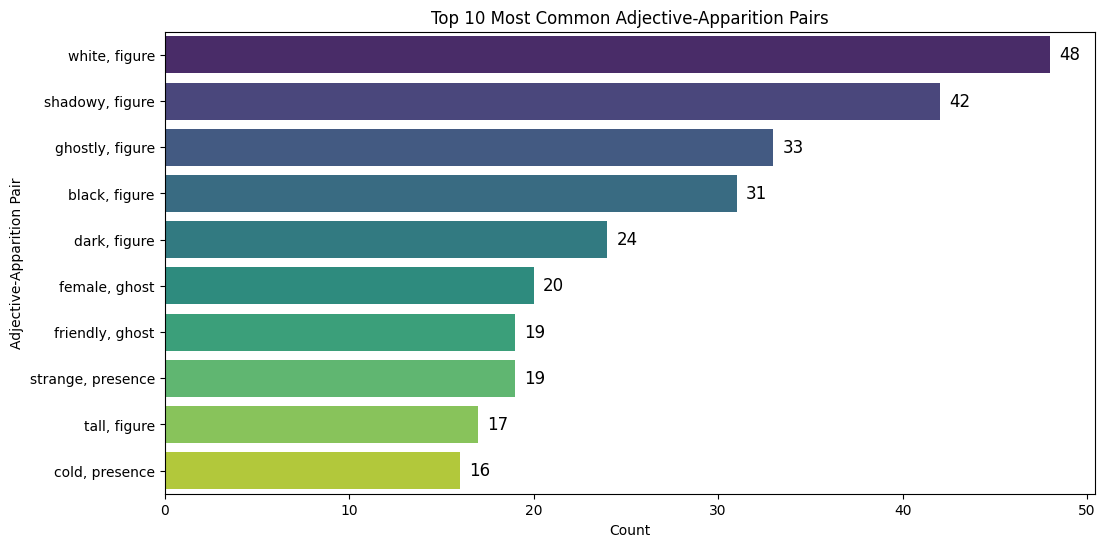

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert tuple keys to strings
adj_app_df = pd.DataFrame(
    [(f"{adj}, {app}", count) for (adj, app), count in pair_counts.items()],
    columns=['Adjective_Apparition', 'Count']
)

# Sort and select top 10 pairs
adj_app_df = adj_app_df.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    y=adj_app_df['Adjective_Apparition'],
    x=adj_app_df['Count'],
    hue=adj_app_df['Adjective_Apparition'],  # Assign `hue` to the categorical variable
    palette="viridis",
    legend=False  # Remove unnecessary legend
)

# Add count labels on the bars
for bar in ax.patches:
    plt.text(
        bar.get_width() + 0.5,  # Offset a bit to the right
        bar.get_y() + bar.get_height() / 2,  # Centered on the bar
        f'{int(bar.get_width())}',  # Convert count to int and display
        va='center',
        fontsize=12
    )

plt.xlabel("Count")
plt.ylabel("Adjective-Apparition Pair")
plt.title("Top 10 Most Common Adjective-Apparition Pairs")
plt.show()



In [ ]:
# Count just the adjectives (ignoring apparition type)
adjective_counts = Counter([adj for adj, app in all_adj_app_pairs])

print(adjective_counts.most_common(20))  # Top 10 most frequent adjectives


[('white', 75), ('black', 62), ('ghostly', 43), ('shadowy', 43), ('strange', 42), ('female', 39), ('dark', 38), ('unknown', 32), ('male', 28), ('friendly', 27), ('evil', 26), ('many', 25), ('tall', 24), ('old', 21), ('cold', 20), ('other', 20), ('little', 19), ('strong', 16), ('large', 15), ('angry', 14)]


### Cosine Similarity Comparison
This uses the Word2Vec pre-trained vectors based on Google News dataset (about 100 billion words). This comparison was to see how closely associated the keywords were to other words in the keyword bank.
https://huggingface.co/fse/word2vec-google-news-300

In [ ]:
import numpy as np
def euclidean(vec1, vec2):
    distance = np.array(vec1) -np.array(vec2)
    squared_sum = np.sum(distance**2)
    return np.sqrt(squared_sum)

def dot_product(vec1, vec2):
    dotproduct = sum(vec1[k] * vec2[k] for k in range(len(vec1)))
    return dotproduct

def vector_norm(vector):
    norm = np.sqrt(dot_product(vector,vector))
    return norm

def cosine_similarity(vec1, vec2):
    thecosine = 0
    thedotproduct = dot_product(vec1, vec2)
    thecosine = thedotproduct/(vector_norm(vec1)*vector_norm(vec2))
    thecosine = np.round(thecosine,4)
    return thecosine

### Google News Word2Vec Model

This is downloading a pre-trained Word2Vec model to see if there are further word embedding associations that can highlight new words to add to the keyword bank.
This takes around 9 minutes to download.

In [ ]:
import gensim.downloader as api
vectors = api.load('word2vec-google-news-300')

# Load known apparition keywords (ensure lowercase & drop NaNs)
kws_apparition = set(keyword_bank_df['Apparition_Types'].dropna().str.lower())
kws_app_descriptors = set(keyword_bank_df['Apparition_Descriptors'].dropna().str.lower())

def similarity_comparison(keywords_1, keywords_2):
    for word in keywords_1:
        closest_word = None
        min_dist = float('inf')

        for compare_word in keywords_2:
            if word == compare_word:
                continue

            distance = euclidean(vectors[word], vectors[compare_word])

            if distance < min_dist:
                min_dist = distance
                closest_word = compare_word

        cosine_sim_calc = cosine_similarity(vectors[word], vectors[closest_word])
        print(f"Closest word to '{word}' is '{closest_word}' with min_dist of {min_dist:.3f} and cosine_similarity of {cosine_sim_calc}")
similarity_comparison(kws_apparition,kws_apparition)
print()
similarity_comparison(kws_apparition,kws_app_descriptors)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Closest word to 'witch' is 'ghost' with min_dist of 3.172 and cosine_similarity of 0.5032
Closest word to 'apparition' is 'ghost' with min_dist of 3.072 and cosine_similarity of 0.5402
Closest word to 'orb' is 'demon' with min_dist of 3.456 and cosine_similarity of 0.4007
Closest word to 'imp' is 'demon' with min_dist of 3.230 and cosine_similarity of 0.4241
Closest word to 'presence' is 'figure' with min_dist of 3.360 and cosine_similarity of 0.11
Closest word to 'poltergeist' is 'ghost' with min_dist of 2.923 and cosine_similarity of 0.5629
Closest word to 'troll' is 'ghost' with min_dist of 3.521 and cosine_similarity of 0.308
Closest word to 'shadow' is 'ghost' with min_dist of 3.129 and cosine_similarity of 0.3677
Closest word to 'ghost' is 'phantom' with min_dist of 2.788 and cosine_similarity of 0.4912
Closest word to 'figure' is 'shadow' with min_dist of 3.233 and cosine_similarity of 0.2295


In [ ]:
def find_closest_words(keyword, all_unique_words):
    if keyword not in vectors:
        print(f"Keyword '{keyword}' not found in Word2Vec model.")
        return []

    closest_words = []
    keyword_vector = vectors[keyword]

    for word in all_unique_words:
        if word in vectors and word != keyword:
          distance = euclidean(keyword_vector, vectors[word])
          closest_words.append((word, distance, cosine_similarity(keyword_vector, vectors[word])))

    # Sort by distance (closest first)
    closest_words.sort(key=lambda x: x[1]) #Sorts by 2nd element of the tuple (distance)
    return closest_words[:10]  # Get the top 10 closest words

In [ ]:
for keyword in kws_apparition:
    closest_words = find_closest_words(keyword, kws_apparition)
    print(f"\nClosest words to '{keyword}':")
    for word, distance, cosine_sim in closest_words:
      print(f" - '{word}' with distance {distance:.3f} and cosince similarity {cosine_sim:.4f}")


Closest words to 'witch':
 - 'ghost' with distance 3.172 and cosince similarity 0.5032
 - 'demon' with distance 3.237 and cosince similarity 0.5219
 - 'vampire' with distance 3.426 and cosince similarity 0.5341
 - 'poltergeist' with distance 3.523 and cosince similarity 0.4709
 - 'imp' with distance 3.569 and cosince similarity 0.3831
 - 'werewolf' with distance 3.644 and cosince similarity 0.4942
 - 'apparition' with distance 3.697 and cosince similarity 0.4372
 - 'phantom' with distance 3.762 and cosince similarity 0.2871
 - 'warlock' with distance 3.765 and cosince similarity 0.4750
 - 'troll' with distance 3.783 and cosince similarity 0.3568

Closest words to 'apparition':
 - 'ghost' with distance 3.072 and cosince similarity 0.5402
 - 'orb' with distance 3.513 and cosince similarity 0.4516
 - 'poltergeist' with distance 3.526 and cosince similarity 0.4736
 - 'demon' with distance 3.589 and cosince similarity 0.4152
 - 'witch' with distance 3.697 and cosince similarity 0.4372
 - '

In [ ]:
for keyword in kws_app_descriptors:
    closest_words = find_closest_words(keyword, kws_app_descriptors)
    print(f"\nClosest words to '{keyword}':")
    for word, distance, cosine_sim in closest_words:
      print(f" - '{word}' with distance {distance:.3f} and cosince similarity {cosine_sim:.4f}")


Closest words to 'vortex':
 - 'swirling' with distance 3.362 and cosince similarity 0.4021
 - 'ectoplasm' with distance 3.423 and cosince similarity 0.3969
 - 'undoubtedly' with distance 3.491 and cosince similarity 0.1204
 - 'bizarre' with distance 3.622 and cosince similarity 0.2209
 - 'resembling' with distance 3.632 and cosince similarity 0.2434
 - 'blob' with distance 3.637 and cosince similarity 0.3675
 - 'malevolent' with distance 3.664 and cosince similarity 0.2822
 - 'fleeting' with distance 3.720 and cosince similarity 0.2091
 - 'shadowy' with distance 3.742 and cosince similarity 0.2574
 - 'foreboding' with distance 3.778 and cosince similarity 0.2230

Closest words to 'swirling':
 - 'undoubtedly' with distance 3.356 and cosince similarity 0.1483
 - 'vortex' with distance 3.362 and cosince similarity 0.4021
 - 'bizarre' with distance 3.405 and cosince similarity 0.2833
 - 'creeping' with distance 3.409 and cosince similarity 0.3409
 - 'foreboding' with distance 3.470 and co

## Haunted Places Dates

The code block below to get the dates will take around an 1hr to run. This block can be skipped if there are time constraints and the following code block that reads in the "haunted_places_with_dates.csv" which is a pre-loaded dataset with the expected output of the "Haunted Places Date" feature.

In [ ]:
#Need to install datefinder
!pip install datefinder
!pip install wikipedia

# This approach uses a mixed pretrained model and conventional package

import pandas as pd
import re
import datefinder
import wikipedia
from dateutil import parser
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import requests
import time
import pickle
from bs4 import BeautifulSoup
import lxml  # Ensure lxml is explicitly imported

CACHE_FILE = "wikipedia_cache.pkl"

# Load Wikipedia cache if it exists
try:
    with open(CACHE_FILE, "rb") as f:
        wikipedia_cache = pickle.load(f)
except FileNotFoundError:
    wikipedia_cache = {}

def save_cache():
    with open(CACHE_FILE, "wb") as f:
        pickle.dump(wikipedia_cache, f)

def haunted_places_datetime_df(df):
    """Processes a DataFrame of haunted places and extracts relevant dates."""
    current_year = datetime.now().year

    date_patterns = [
        r"\b(19\d{2}|20\d{2})\b",
        r"\b(\d{1,2})/(\d{1,2})/(19\d{2}|20\d{2})\b",
        r"\b(\d{1,2})-(\d{1,2})-(19\d{2}|20\d{2})\b",
        r"\b(19\d{2}|20\d{2})/\d{2}\b",
        r"\b(\w{3,9}) (19\d{2}|20\d{2})\b",
        r"\b(19\d{2}|20\d{2})-(\d{2})-(\d{2})\b",
        r"\b(\w{3,9}) (\d{1,2}), (19\d{2}|20\d{2})\b",
        r"\b(\d{1,2}) (\w{3,9}) (19\d{2}|20\d{2})\b",
        r"\b(\d{1,2}) (\w{3,9}), (19\d{2}|20\d{2})\b",
        r"\b(\w{3,9}) (\d{2}) (19\d{2}|20\d{2})\b",
        r"\b(\d{1,2})(th|st|nd|rd)? (\w{3,9}) (19\d{2}|20\d{2})\b",
        r"(\d+) years ago",
        r"\b(early|mid|late) (19\d{2}|20\d{2})s\b"
    ]

    def verify_date_with_wikipedia(place_name):
        if place_name in wikipedia_cache:
            return wikipedia_cache[place_name]

        retries = 3
        for _ in range(retries):
            try:
                truncated_name = place_name[:300]  # Ensure query doesn't exceed Wikipedia's limit
                summary = wikipedia.summary(truncated_name, sentences=2)
                soup = BeautifulSoup(summary, "lxml")
                matches = list(datefinder.find_dates(soup.text))
                if matches:
                    date_found = matches[0].strftime('%Y/%m/%d')
                    wikipedia_cache[place_name] = date_found
                    save_cache()
                    return date_found if datetime.strptime(date_found, '%Y/%m/%d').year <= current_year else '2025/01/01'
            except (wikipedia.exceptions.DisambiguationError, wikipedia.exceptions.PageError, wikipedia.exceptions.WikipediaException, requests.exceptions.RequestException):
                time.sleep(2)
        return None

    def extract_date(description):
        if not isinstance(description, str):
            return '2025/01/01'

        matches = list(datefinder.find_dates(description, source=True))
        valid_dates = []
        for date, text in matches:
            if re.search(r"19\d{2}|20\d{2}", text):
                try:
                    parsed_date = parser.parse(text, fuzzy=True, ignoretz=True)
                    if parsed_date.year <= current_year:
                        valid_dates.append(parsed_date.strftime('%Y/%m/%d'))
                except ValueError:
                    continue

        if valid_dates:
            return valid_dates[0] if datetime.strptime(valid_dates[0], '%Y/%m/%d').year <= current_year else '2025/01/01'

        relative_match = re.search(r"(\d+) years ago", description)
        if relative_match:
            years_ago = int(relative_match.group(1))
            relative_year = current_year - years_ago
            if relative_year <= current_year:
                return f"{relative_year}/01/01"

        for pattern in date_patterns:
            match = re.search(pattern, description)
            if match:
                try:
                    parsed_date = parser.parse(match.group(), fuzzy=True, ignoretz=True)
                    return parsed_date.strftime('%Y/%m/%d') if parsed_date.year <= current_year else '2025/01/01'
                except ValueError:
                    continue

        place_name = description.split('.')[0]
        wiki_date = verify_date_with_wikipedia(place_name)
        if wiki_date:
            return wiki_date

        return '2025/01/01'

    with ThreadPoolExecutor(max_workers=8) as executor:
        df['Haunted Places Date'] = list(executor.map(extract_date, df['description']))

    df['Haunted Places Date'] = pd.to_datetime(df['Haunted Places Date'], errors='coerce').dt.strftime('%Y/%m/%d')
    df.loc[df['Haunted Places Date'].isna() | (pd.to_datetime(df['Haunted Places Date']).dt.year > current_year), 'Haunted Places Date'] = '2025/01/01'

    return df

df = haunted_places_datetime_df(df)
df.head()

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=bca5cbbacc65cdb8dbde0d5927938f51b44a0b70216308d3c1c3c64419ae10d8
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


/usr/local/lib/python3.11/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname M identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


KeyboardInterrupt: 

In [ ]:
df_dates = pd.read_csv("haunted_places_with_dates.csv", sep=",")
df_dates.head()

,State,city,country,description,location,state_abbrev,longitude,latitude,city_longitude,city_latitude,Total Deaths,% Under 21,Haunted Places Date
0,Alabama,Adamsville,United States,The ghost of a young man has been seen by seve...,Bottenfield Middle School,AL,-86.933312,33.594520,-86.956106,33.600939,2208,3.90%,1/14/2013
1,Alabama,Adamsville,United States,The community of Indian Meadows and its sister...,Indian Meadows,AL,NaN,NaN,-86.956106,33.600939,2208,3.90%,1/1/2025
2,Alabama,Alabaster,United States,This is an old cotton mill opened in 1896. The...,Old Buck Creek Cotton Mill,AL,-86.825893,33.231356,-86.816377,33.244281,2208,3.90%,1/1/2025
3,Alabama,Albertville,United States,At night you will hear doors slamming and see ...,Alabama Avenue Middle School,AL,-86.206151,34.260159,-86.208867,34.267594,2208,3.90%,9/22/2006
4,Alabama,Albertville,United States,Some of the workers say that the elevator will...,Albertville Public Library,AL,-86.203214,34.264041,-86.208867,34.267594,2208,3.90%,3/1/1900


In [ ]:
df = df.merge(df_dates[['description', 'Haunted Places Date']], on='description', how='left')
df.head()

,city,country,description,location,state,state_abbrev,longitude,latitude,city_longitude,city_latitude,...,apparition_gender,apparition_age,apparition_types_str,apparition_descriptors_str,apparition_gender_str,apparition_age_str,unique_apparition_mentions,adjectives,unique_app_descriptor_mentions,Haunted Places Date
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,...,"[man, men, husband, wife]",[Unknown],ghost figure witch,ghostly misty,man men husband wife,Unknown,3,"[(misty, figure), (blue, figure)]",2,1/1/2025
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,...,"[girl, them]",[child],Unknown,restless,girl them,child,1,[],1,1/1/2025
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,...,"[father, son, wife, they, them]",[Unknown],spirit,Unknown,father son wife they them,Unknown,1,[],1,3/1/1972
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,...,"[they, them]",[Unknown],Unknown,Unknown,they them,Unknown,1,[],1,3/1/1970
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,...,"[sister, they]",[Unknown],entity,Unknown,sister they,Unknown,1,[],1,1/1/2025


# Merging Provided Datasets

## Alcohol Abuse Statistics Merge

In [ ]:
def merge_haunted_data_with_alcohol_abuse_df(df):
    """Merges a haunted places DataFrame with alcohol abuse statistics."""
    # Pull in formatted table from alcohol abuse statistics
    url = 'https://drugabusestatistics.org/alcohol-abuse-statistics/'
    tables = pd.read_html(url)
    # Set df_alcohol equal to formatted table from url
    df_alcohol = tables[0]
    # Keep only necessary columns
    columns_to_keep = ['State', 'Total Deaths', '% Under 21']
    df_alcohol_filtered = df_alcohol[columns_to_keep]
    # Rename state column in the haunted DataFrame to match alcohol abuse statistics
    df_haunted = df.rename(columns={'state': 'State'})
    # Merge haunted places data with alcohol abuse statistics on 'State'
    merged_df = pd.merge(df_haunted, df_alcohol_filtered, on='State', how='left')
    df = merged_df
    return df

df = merge_haunted_data_with_alcohol_abuse_df(df)
df.head()

,city,country,description,location,State,state_abbrev,longitude,latitude,city_longitude,city_latitude,...,apparition_types_str,apparition_descriptors_str,apparition_gender_str,apparition_age_str,unique_apparition_mentions,adjectives,unique_app_descriptor_mentions,Haunted Places Date,Total Deaths,% Under 21
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,...,ghost figure witch,ghostly misty,man men husband wife,Unknown,3,"[(misty, figure), (blue, figure)]",2,1/1/2025,4548.0,2.6%
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,...,Unknown,restless,girl them,child,1,[],1,1/1/2025,4548.0,2.6%
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,...,spirit,Unknown,father son wife they them,Unknown,1,[],1,3/1/1972,4548.0,2.6%
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,...,Unknown,Unknown,they them,Unknown,1,[],1,3/1/1970,4548.0,2.6%
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,...,entity,Unknown,sister they,Unknown,1,[],1,1/1/2025,4548.0,2.6%


## Daylight by State Merge - USNO Navy

The block below takes around 45min to run with the cache file and 6hrs without. Run the subsequent block below it.

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import time
import pickle
import os

def parse_date(date_str):
    """Parses date strings in multiple formats and extracts the year, month, and day."""
    for fmt in ("%m/%d/%Y", "%Y/%m/%d"):
        try:
            date_obj = datetime.strptime(date_str, fmt)
            month_map = {
                'Jan': 'Jan.', 'Feb': 'Feb.', 'Mar': 'Mar.', 'Apr': 'Apr.', 'May': 'May',
                'Jun': 'June', 'Jul': 'July', 'Aug': 'Aug.', 'Sep': 'Sep.', 'Oct': 'Oct.', 'Nov': 'Nov.', 'Dec': 'Dec.'
            }
            return date_obj.year, month_map.get(date_obj.strftime('%b'), date_obj.strftime('%b')), date_obj.day
        except ValueError:
            continue
    return None, None, None

def load_cache(cache_file):
    """Loads cached daylight data from a pickle file."""
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    return {}

def save_cache(cache, cache_file):
    """Saves daylight data cache to a pickle file."""
    with open(cache_file, 'wb') as f:
        pickle.dump(cache, f)

def extract_daylight_data(response_text, month, day):
    """Parses the HTML response and extracts the daylight duration for the given month and day."""
    soup = BeautifulSoup(response_text, 'html.parser')

    tables = soup.find_all('table')
    if not tables:
        return 'No data found (Check Response Format)'

    table = None
    for tbl in tables:
        if "Duration of Daylight" in tbl.text:
            table = tbl
            break

    if not table:
        return 'No data found (Check Table Structure)'

    rows = table.find_all('tr')
    if len(rows) < 3:
        return 'No data found (Check Table Structure)'

    headers = [cell.text.strip() for cell in rows[1].find_all('td')]
    if not headers:
        return 'No data found (Check Header Structure)'

    if month not in headers:
        return 'No data found (Month Not Available)'

    month_index = headers.index(month)

    for row in rows[2:]:  # Skip header rows
        columns = row.find_all('td')
        if columns and columns[0].text.strip().isdigit():
            row_day = int(columns[0].text.strip())
            if row_day == day:
                return columns[month_index].text.strip() if month_index < len(columns) else 'No data found'

    return 'No data found (Day Not Available)'

def get_daylight_duration(year, month, day, latitude, longitude, cache, cache_file):
    """Fetches daylight duration data from the US Naval Observatory with caching."""
    cache_key = (year, month, day, latitude, longitude)
    if cache_key in cache:
        return cache[cache_key]

    url = f'https://aa.usno.navy.mil/calculated/durdaydark?year={year}&task=0&lat={latitude:.4f}&lon={longitude:.4f}&label=&submit=Get+Data'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    for attempt in range(3):  # Retry up to 3 times
        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()  # Raises an error for HTTP issues

            daylight_data = extract_daylight_data(response.text, month, day)
            cache[cache_key] = daylight_data
            save_cache(cache, cache_file)
            return daylight_data

        except requests.exceptions.RequestException as e:
            time.sleep(2)  # Wait before retrying

    return 'Request Error'

def process_haunted_places_df(df, cache_file="daylight_cache.pkl"):
    """Processes the haunted places DataFrame and fetches daylight duration."""

    df_cleaned = df[['State', 'description', 'city', 'longitude', 'latitude', 'Haunted Places Date']].copy()

    df_cleaned[['Year', 'Month', 'Day']] = df_cleaned['Haunted Places Date'].apply(
        lambda x: pd.Series(parse_date(str(x)) if pd.notna(x) else (None, None, None))
    )

    df_cleaned = df_cleaned.dropna(subset=['longitude', 'latitude', 'Year', 'Month', 'Day'])

    df_cleaned['longitude'] = df_cleaned['longitude'].astype(float)
    df_cleaned['latitude'] = df_cleaned['latitude'].astype(float)

    # Load existing cache
    cache = load_cache(cache_file)

    df_cleaned['Daylight Data USNO Navy'] = df_cleaned.apply(
        lambda row: get_daylight_duration(row['Year'], row['Month'], row['Day'], row['latitude'], row['longitude'], cache, cache_file),
        axis=1
    )

    # Drop unnecessary columns
    df_cleaned = df_cleaned.drop(columns=['Year', 'Month', 'Day'], errors='ignore')
    df = df_cleaned

    return df

df = process_haunted_places_df(df)
df.head()

In [ ]:
df_daylight = pd.read_csv("finalized_df_text_adding_timeanddate.csv", sep=",")
df_daylight.head()

,State,city,country,description,location,state_abbrev,longitude,latitude,city_longitude,city_latitude,...,death_rate_Influenza and pneumonia,death_rate_Suicide,death_rate_Kidney disease,death_rate_CLRD,death_rate_Diabetes,Haunted Places Date,Total Deaths,% Under 21,Daylight Data USNO Navy,Daylight Data TimeandDate
0,Alabama,Adamsville,United States,The ghost of a young man has been seen by seve...,Bottenfield Middle School,AL,-86.933312,33.594520,-86.956106,33.600939,...,21.178947,13.273684,20.957895,52.510526,26.4,2013/01/14,2208,3.9%,10:10,No data found
1,Alabama,Adamsville,United States,The community of Indian Meadows and its sister...,Indian Meadows,AL,NaN,NaN,-86.956106,33.600939,...,21.178947,13.273684,20.957895,52.510526,26.4,2025/01/01,2208,3.9%,09:59,No data found
2,Alabama,Alabaster,United States,This is an old cotton mill opened in 1896. The...,Old Buck Creek Cotton Mill,AL,-86.825893,33.231356,-86.816377,33.244281,...,21.178947,13.273684,20.957895,52.510526,26.4,2025/01/01,2208,3.9%,10:00,No data found
3,Alabama,Albertville,United States,At night you will hear doors slamming and see ...,Alabama Avenue Middle School,AL,-86.206151,34.260159,-86.208867,34.267594,...,21.178947,13.273684,20.957895,52.510526,26.4,2006/09/22,2208,3.9%,12:09,No data found
4,Alabama,Albertville,United States,Some of the workers say that the elevator will...,Albertville Public Library,AL,-86.203214,34.264041,-86.208867,34.267594,...,21.178947,13.273684,20.957895,52.510526,26.4,1900/03/12,2208,3.9%,11:50,No data found


In [ ]:
df = df.merge(df_daylight[['description', 'Daylight Data USNO Navy']], on='description', how='left')
df.head()

,city,country,description,location,State,state_abbrev,longitude,latitude,city_longitude,city_latitude,...,apparition_descriptors_str,apparition_gender_str,apparition_age_str,unique_apparition_mentions,adjectives,unique_app_descriptor_mentions,Haunted Places Date,Total Deaths,% Under 21,Daylight Data USNO Navy
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,...,ghostly misty,man men husband wife,Unknown,3,"[(misty, figure), (blue, figure)]",2,1/1/2025,4548.0,2.6%,09:05
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,...,restless,girl them,child,1,[],1,1/1/2025,4548.0,2.6%,11:22
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,...,Unknown,father son wife they them,Unknown,1,[],1,3/1/1972,4548.0,2.6%,11:16
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,...,Unknown,they them,Unknown,1,[],1,3/1/1970,4548.0,2.6%,11:45
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,...,Unknown,sister they,Unknown,1,[],1,1/1/2025,4548.0,2.6%,09:10


In [ ]:
df_city_sort = df.sort_values(by='city')
df_city_sort.head()

,city,country,description,location,State,state_abbrev,longitude,latitude,city_longitude,city_latitude,...,apparition_descriptors_str,apparition_gender_str,apparition_age_str,unique_apparition_mentions,adjectives,unique_app_descriptor_mentions,Haunted Places Date,Total Deaths,% Under 21,Daylight Data USNO Navy
1637,<>Manteca,United States,Tthere have been may reports of children playi...,Sequoia elementary,California,CA,-122.068543,37.943595,NaN,NaN,...,Unknown,they,children,1,[],1,1/1/2025,15443.0,2.5%,09:35
9786,ARNOLD,United States,every since this place was built there was sai...,WHEREBERG ARNOLD 14 CINE,Missouri,MO,-90.386043,38.409959,-90.377619,38.432832,...,presence ghostly,them,Unknown,3,"[(evil, presence)]",2,3/1/1981,2877.0,3.7%,11:21
10617,Abbeville,United States,The Historical Abbeville Opera House is old en...,Abbeville Opera House,South Carolina,SC,-82.377870,34.177567,-82.379015,34.178172,...,Unknown,Unknown,Unknown,1,[],1,1/1/2025,2586.0,3.2%,09:56
4518,Abercrombie,United States,ghostly Indians and soldiers have been seen here.,Fort Abercrombie,North Dakota,ND,-96.719415,46.444854,-96.730356,46.447738,...,ghostly,Unknown,Unknown,1,[],1,1/1/2025,347.0,2.6%,08:40
10132,Aberdeen,United States,Jerde Hall - A few students who live on the fo...,Northern State University,South Dakota,SD,-98.484492,45.451099,-98.486483,45.464698,...,Unknown,girl,child,1,[],1,1/1/2025,463.0,3.9%,08:48


## Daylight by State Merge - TimeandDate

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pickle
import os

def parse_date(date_str):
    """Parses date strings in multiple formats and extracts the year, month, and day."""
    for fmt in ("%m/%d/%Y", "%Y/%m/%d"):
        try:
            date_obj = datetime.strptime(date_str, fmt)
            return date_obj.year, date_obj.month, date_obj.day
        except ValueError:
            continue
    return None, None, None

def load_cache(cache_file):
    """Loads cached daylight data from a pickle file."""
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    return {}

def save_cache(cache, cache_file):
    """Saves daylight data cache to a pickle file."""
    with open(cache_file, 'wb') as f:
        pickle.dump(cache, f)

def format_city_state(city, state):
    """Formats the city and state for the Time and Date website URL using the state abbreviation."""
    city = city.lower().replace(" ", "-").replace(".", "").replace(",", "")
    state_abbreviation = state.lower()[:2]  # Use only the first two letters as the state abbreviation
    return f"{city}-{state_abbreviation}", city

def get_daylight_from_timeanddate(city, state, month, day, year, cache, cache_file):
    """Fetches daylight duration from Time and Date website with caching and error handling."""
    cache_key = (city, state, month, day, year)
    if cache_key in cache:
        return cache[cache_key]

    formatted_location, city_only = format_city_state(city, state)
    url_variants = [
        f"https://www.timeanddate.com/sun/usa/{formatted_location}?month={month}&year={year}",
        f"https://www.timeanddate.com/sun/usa/{city_only}?month={month}&year={year}"
    ]

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    for url in url_variants:
        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, 'html.parser')

            daylight_table = soup.find("table", id="as-monthsun")
            if not daylight_table:
                continue

            rows = daylight_table.find_all("tr", attrs={"data-day": str(day)})
            if not rows:
                continue

            cols = rows[0].find_all("td")
            if len(cols) > 2:
                daylight_duration = cols[2].text.strip().split(":")[:2]  # Extract only HH:MM format
                daylight_duration = daylight_duration[0] + ":" + daylight_duration[1]  # Ensure HH:MM format
                cache[cache_key] = daylight_duration
                save_cache(cache, cache_file)
                return daylight_duration
        except requests.exceptions.RequestException:
            continue

    return "No data found"

def process_haunted_places_timeanddate_df(df, cache_file="timeanddate_cache.pkl"):
    """Processes the haunted places DataFrame and fetches daylight duration from Time and Date."""

    df[['Year', 'Month', 'Day']] = df['Haunted Places Date'].apply(
        lambda x: pd.Series(parse_date(str(x)) if pd.notna(x) else (None, None, None))
    )

    df = df.dropna(subset=['Year', 'Month', 'Day'])

    cache = load_cache(cache_file)

    df['Daylight Data TimeandDate'] = df.apply(
        lambda row: get_daylight_from_timeanddate(row['city'], row['State'], row['Month'], row['Day'], row['Year'], cache, cache_file),
        axis=1
    )

    df = df.drop(columns=['Year', 'Month', 'Day'])

    return df

df = process_haunted_places_timeanddate_df(df)
df.head()

KeyboardInterrupt: 

In [ ]:
df_timeanddate = pd.read_csv("finalized_df_text_adding_timeanddate.csv", sep=",")
df_timeanddate.head()

,State,city,country,description,location,state_abbrev,longitude,latitude,city_longitude,city_latitude,...,death_rate_Influenza and pneumonia,death_rate_Suicide,death_rate_Kidney disease,death_rate_CLRD,death_rate_Diabetes,Haunted Places Date,Total Deaths,% Under 21,Daylight Data USNO Navy,Daylight Data TimeandDate
0,Alabama,Adamsville,United States,The ghost of a young man has been seen by seve...,Bottenfield Middle School,AL,-86.933312,33.594520,-86.956106,33.600939,...,21.178947,13.273684,20.957895,52.510526,26.4,2013/01/14,2208,3.9%,10:10,No data found
1,Alabama,Adamsville,United States,The community of Indian Meadows and its sister...,Indian Meadows,AL,NaN,NaN,-86.956106,33.600939,...,21.178947,13.273684,20.957895,52.510526,26.4,2025/01/01,2208,3.9%,09:59,No data found
2,Alabama,Alabaster,United States,This is an old cotton mill opened in 1896. The...,Old Buck Creek Cotton Mill,AL,-86.825893,33.231356,-86.816377,33.244281,...,21.178947,13.273684,20.957895,52.510526,26.4,2025/01/01,2208,3.9%,10:00,No data found
3,Alabama,Albertville,United States,At night you will hear doors slamming and see ...,Alabama Avenue Middle School,AL,-86.206151,34.260159,-86.208867,34.267594,...,21.178947,13.273684,20.957895,52.510526,26.4,2006/09/22,2208,3.9%,12:09,No data found
4,Alabama,Albertville,United States,Some of the workers say that the elevator will...,Albertville Public Library,AL,-86.203214,34.264041,-86.208867,34.267594,...,21.178947,13.273684,20.957895,52.510526,26.4,1900/03/12,2208,3.9%,11:50,No data found


In [ ]:
df = df.merge(df_timeanddate[['description','Daylight Data TimeandDate']], on='description', how='left')
df.head()

,city,country,description,location,State,state_abbrev,longitude,latitude,city_longitude,city_latitude,...,apparition_gender_str,apparition_age_str,unique_apparition_mentions,adjectives,unique_app_descriptor_mentions,Haunted Places Date,Total Deaths,% Under 21,Daylight Data USNO Navy,Daylight Data TimeandDate
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,...,man men husband wife,Unknown,3,"[(misty, figure), (blue, figure)]",2,1/1/2025,4548.0,2.6%,09:05,No data found
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,...,girl them,child,1,[],1,1/1/2025,4548.0,2.6%,11:22,No data found
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,...,father son wife they them,Unknown,1,[],1,3/1/1972,4548.0,2.6%,11:16,No data found
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,...,they them,Unknown,1,[],1,3/1/1970,4548.0,2.6%,11:45,No data found
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,...,sister they,Unknown,1,[],1,1/1/2025,4548.0,2.6%,09:10,No data found


# 3 MIME Type Datasets

## FBI Crime Data
https://realtimecrimeindex.com/
* FBI defined geographical regions (Midwest/Northwest/South/West)
* Crime types (broad and sub-types) with count and 12 month rolling sum
* date (Month and Year), no days

In 2021, 37% of police departments nationwide, including Los Angeles and New York, stopped reporting crime data to the FBI.
https://crimeresearch.org/2024/04/how-reliable-are-the-fbis-report-of-violent-crime-data-there-are-some-major-problems/
https://www.themarshallproject.org/2023/07/13/fbi-crime-rates-data-gap-nibrs

In [ ]:
fbi_df = pd.read_csv('FBI_crime_data.csv')
print(fbi_df.describe())

              Month          Year        Murder          Rape       Robbery  \
count  38687.000000  38687.000000  38627.000000  37361.000000  38202.000000   
mean       6.488252   2020.990695      7.895798     34.970022    106.264646   
std        3.447843      1.996188     43.918210    184.583003    584.116523   
min        1.000000   2018.000000     -3.000000     -3.000000     -1.000000   
25%        3.000000   2019.000000      0.000000      1.000000      1.000000   
50%        6.000000   2021.000000      0.000000      4.000000      5.000000   
75%        9.000000   2023.000000      2.000000     11.000000     22.000000   
max       12.000000   2024.000000   1053.000000   3540.000000  11848.000000   

       Aggravated Assault      Burglary          Theft  Motor Vehicle Theft  \
count        38118.000000  38118.000000   38202.000000         38202.000000   
mean           276.434073    275.126764    1355.828150           319.995445   
std           1492.186616   1487.688947    7282.543

<ipython-input-161-ad94c33949be>:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  fbi_df = pd.read_csv('FBI_crime_data.csv')


In [ ]:
state_row_count = fbi_df.groupby('State').size()
print(state_row_count)

State
AR             168
AZ            1761
CA            2350
CO            1678
CT            1677
DC             168
FL             168
GA             336
HI             168
ID             755
IL            1594
IN             334
KY             252
LA             247
MA            2389
MD             168
MI            2345
MN            1680
MO            1175
MS             168
NC             588
NE             420
NH             252
NJ             250
NM             168
NV             502
NY             420
Nationwide     756
OH            2009
OR            1081
PA            1595
PR             913
RI             420
SD             252
TN            1344
TX            6036
UT             168
VA            1092
WA             420
WI             252
WY             168
dtype: int64


In [ ]:
filtered_fbi_df = fbi_df.loc[(fbi_df['Agency'] == 'Full Sample') & (fbi_df['State'] != 'Nationwide') & (fbi_df['Source.Type'] == 'Aggregate')]

print(filtered_fbi_df.head())

       Month  Year          Date       Agency State     Region  \
34498      1  2018  January 2018  Full Sample    AR      South   
34499      1  2018  January 2018  Full Sample    AZ       West   
34500      1  2018  January 2018  Full Sample    CA       West   
34501      1  2018  January 2018  Full Sample    CO       West   
34502      1  2018  January 2018  Full Sample    CT  Northeast   

          Agency_State  Murder   Rape  Robbery  ...  Property Crime_mvs_12mo  \
34498  Full Sample, AR     3.0   15.0     31.0  ...                  13724.0   
34499  Full Sample, AZ    26.0  266.0    565.0  ...                 142574.0   
34500  Full Sample, CA    61.0  189.0   1059.0  ...                 204479.0   
34501  Full Sample, CO    15.0  330.0    306.0  ...                  98457.0   
34502  Full Sample, CT     7.0   33.0    144.0  ...                  30186.0   

                                             Source.Link  Source.Type  \
34498  https://ah-datalytics.github.io/rtci/list/

In [ ]:
agg_fbi_df = filtered_fbi_df.groupby('State').sum(numeric_only=True).reset_index()
print(agg_fbi_df.describe())
print(agg_fbi_df.columns)

       Month      Year       Murder          Rape        Robbery  \
count   39.0      39.0    39.000000     39.000000      39.000000   
mean   546.0  169764.0  1536.435897   6574.538462   20559.410256   
std      0.0       0.0  1750.792073  10413.728057   29324.901878   
min    546.0  169764.0     4.000000      0.000000       0.000000   
25%    546.0  169764.0   221.000000   1283.000000    2236.000000   
50%    546.0  169764.0  1057.000000   3036.000000   11524.000000   
75%    546.0  169764.0  2217.000000   8525.500000   23794.000000   
max    546.0  169764.0  8253.000000  60461.000000  130477.000000   

       Aggravated Assault       Burglary         Theft  Motor Vehicle Theft  \
count           39.000000      39.000000  3.900000e+01            39.000000   
mean         53145.564103   52875.923077  2.613122e+05         61853.025641   
std          72423.323600   75737.497254  3.686514e+05         83710.587927   
min              0.000000       0.000000  0.000000e+00             0.00

In [ ]:
for column_name in ['Murder', 'Rape', 'Robbery', 'Aggravated Assault', 'Burglary', 'Theft', 'Motor Vehicle Theft', 'Violent Crime', 'Property Crime']:
    agg_fbi_df[f'{column_name} per capita'] = agg_fbi_df[column_name]/agg_fbi_df['FBI.Population.Covered']

print(agg_fbi_df.columns)

Index(['State', 'Month', 'Year', 'Murder', 'Rape', 'Robbery',
       'Aggravated Assault', 'Burglary', 'Theft', 'Motor Vehicle Theft',
       'Violent Crime', 'Property Crime', 'Murder_mvs_12mo',
       'Burglary_mvs_12mo', 'Rape_mvs_12mo', 'Robbery_mvs_12mo',
       'Aggravated Assault_mvs_12mo', 'Motor Vehicle Theft_mvs_12mo',
       'Theft_mvs_12mo', 'Violent Crime_mvs_12mo', 'Property Crime_mvs_12mo',
       'FBI.Population.Covered', 'Number.of.Agencies', 'Latitude', 'Longitude',
       'Murder per capita', 'Rape per capita', 'Robbery per capita',
       'Aggravated Assault per capita', 'Burglary per capita',
       'Theft per capita', 'Motor Vehicle Theft per capita',
       'Violent Crime per capita', 'Property Crime per capita'],
      dtype='object')


In [ ]:
sorted_VCPC_fbi_df = agg_fbi_df.sort_values(by=['Violent Crime per capita'], ascending=False)
print(sorted_VCPC_fbi_df[['State', 'Violent Crime per capita']].head(10))

sorted_PCPC_fbi_df = agg_fbi_df.sort_values(by=['Property Crime per capita'], ascending=False)
print(sorted_PCPC_fbi_df[['State', 'Property Crime per capita']].head(10))

   State  Violent Crime per capita
15    MD                  0.001672
0     AR                  0.001428
32    TN                  0.000967
11    IN                  0.000827
18    MO                  0.000795
13    LA                  0.000736
10    IL                  0.000688
34    UT                  0.000676
6     FL                  0.000622
16    MI                  0.000602
   State  Property Crime per capita
6     FL                   0.006685
34    UT                   0.005132
0     AR                   0.004587
36    WA                   0.004521
28    OR                   0.004292
13    LA                   0.004087
15    MD                   0.003464
32    TN                   0.003459
7     GA                   0.003350
5     DC                   0.003255


In [ ]:
print(agg_fbi_df.columns)
print(agg_fbi_df.head())

Index(['State', 'Month', 'Year', 'Murder', 'Rape', 'Robbery',
       'Aggravated Assault', 'Burglary', 'Theft', 'Motor Vehicle Theft',
       'Violent Crime', 'Property Crime', 'Murder_mvs_12mo',
       'Burglary_mvs_12mo', 'Rape_mvs_12mo', 'Robbery_mvs_12mo',
       'Aggravated Assault_mvs_12mo', 'Motor Vehicle Theft_mvs_12mo',
       'Theft_mvs_12mo', 'Violent Crime_mvs_12mo', 'Property Crime_mvs_12mo',
       'FBI.Population.Covered', 'Number.of.Agencies', 'Latitude', 'Longitude',
       'Murder per capita', 'Rape per capita', 'Robbery per capita',
       'Aggravated Assault per capita', 'Burglary per capita',
       'Theft per capita', 'Motor Vehicle Theft per capita',
       'Violent Crime per capita', 'Property Crime per capita'],
      dtype='object')
  State  Month    Year  Murder     Rape  Robbery  Aggravated Assault  \
0    AR    546  169764   387.0   1349.0   2840.0             19781.0   
1    AZ    546  169764  2303.0  17665.0  32091.0             97062.0   
2    CA    546 

### FBI Join with Haunted Df (Aggregated)

In [ ]:
print(df.head())

#Grouping haunted df by states and returning sums
agg_df_by_state = df.groupby('state_abbrev').sum(numeric_only=True).reset_index()

#Merging aggregated datasets
merged_fbi_df = pd.merge(agg_df_by_state, agg_fbi_df, left_on='state_abbrev', right_on = 'State', how = 'left')
print(merged_fbi_df.head())
merged_fbi_df.to_csv('merged_fbi_df.csv')

      city        country                                        description  \
0      Ada  United States  Ada witch - Sometimes you can see a misty blue...   
1  Addison  United States  A little girl was killed suddenly while waitin...   
2   Adrian  United States  If you take Gorman Rd. west towards Sand Creek...   
3   Adrian  United States  In the 1970's, one room, room 211, in the old ...   
4   Albion  United States  Kappa Delta Sorority - The Kappa Delta Sororit...   

                   location     State state_abbrev  longitude   latitude  \
0              Ada Cemetery  Michigan           MI -85.504893  42.962106   
1           North Adams Rd.  Michigan           MI -84.381843  41.971425   
2             Ghost Trestle  Michigan           MI -84.035656  41.904538   
3  Siena Heights University  Michigan           MI -84.017565  41.905712   
4            Albion College  Michigan           MI -84.745177  42.244006   

   city_longitude  city_latitude  ...      apparition_gender_s

In [ ]:
df_state_row_counts = df.groupby('state_abbrev').size().reset_index(name='haunted_entry_counts')
print(df_state_row_counts.head())

merged_fbi_df = merged_fbi_df.merge(df_state_row_counts, on='state_abbrev', how='left')
print(merged_fbi_df[['state_abbrev', 'haunted_entry_counts']].head())

  state_abbrev  haunted_entry_counts
0           AK                    32
1           AL                   224
2           AR                   119
3           AZ                   156
4           CA                  1084
  state_abbrev  haunted_entry_counts
0           AK                    32
1           AL                   224
2           AR                   119
3           AZ                   156
4           CA                  1084


In [ ]:
merged_fbi_df['apparition_per_state_entry'] = merged_fbi_df['unique_apparition_mentions']/merged_fbi_df['haunted_entry_counts']
print(merged_fbi_df[['state_abbrev', 'haunted_entry_counts', 'apparition_per_state_entry']])

   state_abbrev  haunted_entry_counts  apparition_per_state_entry
0            AK                    32                    1.125000
1            AL                   224                    1.089286
2            AR                   119                    1.084034
3            AZ                   156                    1.128205
4            CA                  1084                    1.142066
5            CO                   166                    1.192771
6            CT                   185                    1.189189
7            DC                    16                    1.062500
8            DE                    37                    1.162162
9            FL                   328                    1.149390
10           GA                   289                    1.100346
11           HI                    96                    1.062500
12           IA                   169                    1.065089
13           ID                    66                    1.166667
14        

In [ ]:
merged_fbi_df_sorted = merged_fbi_df.sort_values(by=['unique_apparition_mentions', 'Violent Crime'], ascending=[False, False])

# Display the top 5 rows after sorting
print(merged_fbi_df_sorted[['state_abbrev', 'unique_apparition_mentions', 'Violent Crime', 'Property Crime','Violent Crime per capita', 'Property Crime per capita']].head(10))

   state_abbrev  unique_apparition_mentions  Violent Crime  Property Crime  \
4            CA                        1238       239158.0       1300112.0   
43           TX                         776       579712.0       3032899.0   
38           PA                         741       134325.0        532908.0   
22           MI                         619       133908.0        395951.0   
35           OH                         534       103553.0        398639.0   
34           NY                         521       315003.0        606687.0   
14           IL                         449       220037.0        728507.0   
17           KY                         400        40716.0        252392.0   
15           IN                         397        68771.0        245733.0   
19           MA                         384        73282.0        220503.0   

    Violent Crime per capita  Property Crime per capita  
4                   0.000272                   0.001479  
43                  0.000

In [ ]:
import numpy as np
# Replace zeros in Property Crime and Violent Crime columns with NaN
merged_fbi_df_sorted['Violent Crime'] = merged_fbi_df_sorted['Violent Crime'].replace(0, np.nan)
merged_fbi_df_sorted['Property Crime'] = merged_fbi_df_sorted['Property Crime'].replace(0, np.nan)

# Calculate the ratio between 'unique_apparition_mentions' and 'Violent Crime'
merged_fbi_df_sorted['Apparition_ViolentCrime_Ratio'] = merged_fbi_df_sorted['unique_apparition_mentions'] / merged_fbi_df_sorted['Violent Crime']

# Calculate the ratio between 'unique_apparition_mentions' and 'Property Crime'
merged_fbi_df_sorted['Apparition_PropertyCrime_Ratio'] = merged_fbi_df_sorted['unique_apparition_mentions'] / merged_fbi_df_sorted['Property Crime']

# Display the first few rows to check the new columns
print(merged_fbi_df_sorted[['state_abbrev', 'unique_apparition_mentions', 'Violent Crime', 'Property Crime', 'Apparition_ViolentCrime_Ratio', 'Apparition_PropertyCrime_Ratio']].head())


   state_abbrev  unique_apparition_mentions  Violent Crime  Property Crime  \
4            CA                        1238       239158.0       1300112.0   
43           TX                         776       579712.0       3032899.0   
38           PA                         741       134325.0        532908.0   
22           MI                         619       133908.0        395951.0   
35           OH                         534       103553.0        398639.0   

    Apparition_ViolentCrime_Ratio  Apparition_PropertyCrime_Ratio  
4                        0.005176                        0.000952  
43                       0.001339                        0.000256  
38                       0.005516                        0.001390  
22                       0.004623                        0.001563  
35                       0.005157                        0.001340  


In [ ]:
# Group by state_abbrev and calculate the mean of the ratios
# Selecting only the numeric columns for the mean calculation
grouped_by_apparition_violentcrime = merged_fbi_df_sorted.groupby('state_abbrev')[['Apparition_ViolentCrime_Ratio']].mean()
grouped_by_apparition_propertycrime = merged_fbi_df_sorted.groupby('state_abbrev')[['Apparition_PropertyCrime_Ratio']].mean()

# Sort the ratios in descending order
sorted_by_apparition_violentcrime = grouped_by_apparition_violentcrime.sort_values(by='Apparition_ViolentCrime_Ratio', ascending=False)
sorted_by_apparition_propertycrime = grouped_by_apparition_propertycrime.sort_values(by='Apparition_PropertyCrime_Ratio', ascending=False)

# Print the top 5 states sorted by Apparition-to-Violent Crime Ratio
print("Top 10 States by Apparition-to-Violent Crime Ratio:")
print(sorted_by_apparition_violentcrime.head(10))

# Print the top 5 states sorted by Apparition-to-Property Crime Ratio
print("\nTop 10 States by Apparition-to-Property Crime Ratio:")
print(sorted_by_apparition_propertycrime.head(10))

Top 10 States by Apparition-to-Violent Crime Ratio:
              Apparition_ViolentCrime_Ratio
state_abbrev                               
NJ                                 0.380306
NM                                 0.135802
WI                                 0.135403
FL                                 0.091505
MS                                 0.076571
WY                                 0.057410
NH                                 0.019152
UT                                 0.013457
GA                                 0.011404
RI                                 0.011103

Top 10 States by Apparition-to-Property Crime Ratio:
              Apparition_PropertyCrime_Ratio
state_abbrev                                
NJ                                  0.073346
WI                                  0.042307
FL                                  0.008518
MS                                  0.005749
WY                                  0.005393
NH                                  0.003508
GA    

### FBI Join with Haunted Df (Line item)

In [ ]:
merged_fbi_df = pd.merge(agg_df_by_state, agg_fbi_df, left_on='state_abbrev', right_on = 'State', how = 'left')

select_cols_fbi_df = merged_fbi_df[['state_abbrev', 'FBI.Population.Covered', 'Murder per capita', 'Violent Crime per capita', 'Property Crime per capita']]

# Merge the aggregated ratios and calculations back into the original DataFrame to prepare it for Tika Similarity
df_merged_with_fbi = pd.merge(df, select_cols_fbi_df, on='state_abbrev', how='left')
df_merged_with_fbi.to_csv('fbi_merged_line_item.csv', index=False)

df = df_merged_with_fbi

In [ ]:
print(df.columns)

Index(['city', 'country', 'description', 'location', 'State', 'state_abbrev',
       'longitude', 'latitude', 'city_longitude', 'city_latitude',
       'clean_description', 'clean_spelling', 'Audio Evidence',
       'Audio Reasoning', 'time_of_day', 'visual_evidence', 'reasoning',
       'Witness Count', 'Witness Reasoning', 'tokenized', 'pos_tokenized',
       'filtered_tokenized', 'lemma_filtered_tokenized', 'lemma_pos_tokenized',
       'Event', 'apparition_types', 'apparition_descriptors',
       'apparition_gender', 'apparition_age', 'apparition_types_str',
       'apparition_descriptors_str', 'apparition_gender_str',
       'apparition_age_str', 'unique_apparition_mentions', 'adjectives',
       'unique_app_descriptor_mentions', 'Haunted Places Date', 'Total Deaths',
       '% Under 21', 'Daylight Data USNO Navy', 'Daylight Data TimeandDate',
       'FBI.Population.Covered', 'Murder per capita',
       'Violent Crime per capita'],
      dtype='object')


## US Leading Causes of Death
https://catalog.data.gov/dataset/nchs-leading-causes-of-death-united-states

This dataset presents the age-adjusted death rates for the 10 leading causes of death in the United States beginning in 1999.

Data are based on information from all resident death certificates filed in the 50 states and the District of Columbia using demographic and medical characteristics. Age-adjusted death rates (per 100,000 population) are based on the 2000 U.S. standard population. Populations used for computing death rates after 2010 are postcensal estimates based on the 2010 census, estimated as of July 1, 2010. Rates for census years are based on populations enumerated in the corresponding censuses. Rates for non-census years before 2010 are revised using updated intercensal population estimates and may differ from rates previously published.

**Note: The code below uses the age adjusted death rate rather than the # of deaths**

In [ ]:
import numpy as np
import pandas as pd
import json
import requests
import warnings
warnings.filterwarnings(
    action='ignore', category=UserWarning, message=r"Boolean Series.*"
)

# get column names from JSON dictionary
def get_json_column_names(data: dict) -> list[str]:
    column_names = list()

    columns_frame = data['meta']['view']['columns']
    for frame in columns_frame:
        column_name = frame['name']
        column_names.append(column_name)

    return column_names

# process JSON into dictionary
def json_to_df(json_path: str) -> pd.DataFrame:
    # read json into dict using json.load()
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)

    # get columns
    column_names = get_json_column_names(data=data)

    # get rows
    df_json = pd.DataFrame(columns=column_names)
    for index, datapoint in enumerate(data['data']):
        df_json.loc[index] = datapoint

    selected_columns = ['State', 'Cause Name', 'Year', 'Deaths', 'Age-adjusted Death Rate']
    return df_json[selected_columns]

# aggregrate JSON dictionary into JSON dataframe (df_final)
def aggregate_df_json(df_json: pd.DataFrame) -> pd.DataFrame:
    # AGGREGRATION: aggregate mean with tuple (state, cause name) as index
    df = df_json.groupby(["State", "Cause Name"]).agg('mean').drop('Year', axis=1)

    columns = ["State", "Cause Name", "Deaths", "Age-adjusted Death Rate"]
    df_agg = pd.DataFrame(columns=columns)

    # unpack index
    for index, row in df.iterrows():
        state, cause = index
        deaths = row['Deaths']
        age_death = row['Age-adjusted Death Rate']
        df_agg.loc[len(df_agg)] = [state, cause, deaths, age_death]

    # ORGANIZE COLUMNS: [state, death_rate{cause[0]}, death_rate{cause[1]}, ...]
    # Yields df_final
    states = list(set(df_agg.State.values))
    causes = list(set(df_agg["Cause Name"].values))
    columns = ["state"] + [f"death_rate_{cause}" for cause in causes]

    df_final = pd.DataFrame(columns=columns)
    for state in states:
        row = [state]
        for cause in causes:
            death_rate = df_agg[df_agg.State == state][df_agg['Cause Name'] == cause]["Age-adjusted Death Rate"].values[0]
            row.append(death_rate)
        df_final.loc[len(df_final)] = row

    return df_final

# join Haunted DataFrame (df) with JSON DataFrame (json_path -> df_json -> df_agg)
def join(df: pd.DataFrame, json_path: str) -> pd.DataFrame:
    #df_json = json_to_df(json_path=json_path) # process json into df, might take a couple minutes
    #df_json.to_csv('df_json.csv', index=False) # can also be found in google drive
    df_json = pd.read_csv('df_json.csv')

    # aggregate on state
    df_agg = aggregate_df_json(df_json=df_json).set_index('state')
    #print(df_agg)

    # join manually, df.join() not working
    new_col_names = list(df_agg.columns)[1:]
    new_col_dict = {}
    for new_col in new_col_names:
        new_col_dict[new_col] = list()

    for index, row in df.iterrows():
        state = row['State']
        for col in new_col_names: # death_rate_{cause}
            if state == 'Washington DC':
                new_col_dict[col].append(None)
                continue
            value = df_agg.loc[state][col]
            new_col_dict[col].append(value)

    for key, value in new_col_dict.items():
        df[key] = value

    return df

df = df.copy()
json_path = 'causes.json' # can be found in google drive
df_joined = join(df=df, json_path=json_path)

print(f"Columns: {list(df_joined.columns)}")
print("")
df_joined.to_csv('deathCauses_merged_line_item.csv', index=False)
print("Joined dataset saved in 'deathCauses_merged_line_item.csv'")

Columns: ['city', 'country', 'description', 'location', 'State', 'state_abbrev', 'longitude', 'latitude', 'city_longitude', 'city_latitude', 'clean_description', 'clean_spelling', 'Audio Evidence', 'Audio Reasoning', 'time_of_day', 'visual_evidence', 'reasoning', 'Witness Count', 'Witness Reasoning', 'tokenized', 'pos_tokenized', 'filtered_tokenized', 'lemma_filtered_tokenized', 'lemma_pos_tokenized', 'Event', 'apparition_types', 'apparition_descriptors', 'apparition_gender', 'apparition_age', 'apparition_types_str', 'apparition_descriptors_str', 'apparition_gender_str', 'apparition_age_str', 'unique_apparition_mentions', 'adjectives', 'unique_app_descriptor_mentions', 'Haunted Places Date', 'Total Deaths', '% Under 21', 'Daylight Data USNO Navy', 'Daylight Data TimeandDate', 'FBI.Population.Covered', 'Murder per capita', 'Violent Crime per capita', 'death_rate_Kidney disease', 'death_rate_Stroke', 'death_rate_Influenza and pneumonia', 'death_rate_Cancer', 'death_rate_Unintentional inj

In [ ]:
# Set new df columns from 'deathCauses_merge_line_item.csv'
df_joined = pd.read_csv('deathCauses_merged_line_item.csv')
for column in [x for x in list(df_joined.columns) if x.startswith('death_rate_')]:
    df[column] = df_joined[column].astype(float)

Analysis of Death Data:

In [ ]:
#lists each state, the amount of hauntings, and the death rates

import pandas as pd
from google.colab.data_table import DataTable  # Enables interactive display in Colab

df_copy = df.copy()

df_copy.columns = df_copy.columns.str.lower().str.strip()

#Count the number of haunted encounters per state
haunted_counts_by_state = df_copy["state"].value_counts().rename("haunted_encounter_count")

#Select death rate columns
column_subset = df_copy.iloc[:, 10:22]  # Adjust this range if columns are misaligned

#Compute the mean values for each state for selected columns
state_aggregated_data = df_copy.groupby("state")[column_subset.columns].mean(numeric_only=True)

#Merge the haunted count with the death rate columns
final_df = haunted_counts_by_state.to_frame().merge(state_aggregated_data, left_index=True, right_index=True)

csv_filename = "states_death_rates.csv"
final_df.to_csv(csv_filename, index=True)

display(DataTable(final_df))


,haunted_encounter_count,visual_evidence
state,,
California,1084,0.024908
Texas,703,0.028450
Pennsylvania,649,0.027735
Michigan,543,0.055249
Ohio,477,0.023061
New York,459,0.028322
Illinois,395,0.053165
Kentucky,370,0.035135
Indiana,365,0.035616


In [ ]:
df.columns

Index(['city', 'country', 'description', 'location', 'State', 'state_abbrev',
       'longitude', 'latitude', 'city_longitude', 'city_latitude',
       'clean_description', 'clean_spelling', 'Audio Evidence',
       'Audio Reasoning', 'time_of_day', 'visual_evidence', 'reasoning',
       'Witness Count', 'Witness Reasoning', 'tokenized', 'pos_tokenized',
       'filtered_tokenized', 'lemma_filtered_tokenized', 'lemma_pos_tokenized',
       'Event', 'apparition_types', 'apparition_descriptors',
       'apparition_gender', 'apparition_age', 'apparition_types_str',
       'apparition_descriptors_str', 'apparition_gender_str',
       'apparition_age_str', 'unique_apparition_mentions', 'adjectives',
       'unique_app_descriptor_mentions', 'Haunted Places Date', 'Total Deaths',
       '% Under 21', 'Daylight Data USNO Navy', 'Daylight Data TimeandDate',
       'FBI.Population.Covered', 'Murder per capita',
       'Violent Crime per capita', 'death_rate_Kidney disease',
       'death_rate_St

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure 'correlations' exists by recalculating it if needed
if 'correlations' not in globals():
    correlations = {}
    death_cause_columns = [col for col in df.columns if "death_rate" in col.lower()]
    print(death_cause_columns)
    for col in death_cause_columns:
        correlation = np.corrcoef(df[col], df["haunted_encounter_count"])[0, 1]
        correlations[col] = correlation

# Create a folder to save plots
output_folder = "death_rates_scatter_plots"
os.makedirs(output_folder, exist_ok=True)

print(death_cause_columns)
for i, col in enumerate(death_cause_columns):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[col], y=df["haunted_encounter_count"])
    plt.title(f"Ghost Sightings vs {col} (Corr: {correlations[col]:.2f})")
    plt.xlabel(col)
    plt.ylabel("Number of Haunted Encounters")

    # Save each individual plot
    plot_filename = f"{output_folder}/scatter_{col}.png"
    plt.savefig(plot_filename)
    print(f"Saved: {plot_filename}")

    plt.show()


[]


MERGE all 3 MIME dataset back into main "df"

# JPEG

Original Idea using computer vision library to read jpeg files and obtain results of education of undergraduate graduation rates, high school graduation rates, and STEM graduation rates. although lots of fine tune testing was done, results are subpar, so will yeiled very poor results. This block only displays for the undergrad.jpeg file



In [ ]:
# THIS CODE yields very poor results :(
import cv2
!pip install pytesseract
import pytesseract
import re
import matplotlib.pyplot as plt

image_path = "undergrad.jpeg"
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Image not found at {image_path}")

# original image shape
h, w, _ = image.shape
print("Original image dimensions:", image.shape)

# crop image
cropped = image[50:h-50, 0:w]


# grayscale image for readability
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

# apply adaptive thresholding to handle variations in text/background
thresh = cv2.adaptiveThreshold(gray, 255,
                               cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY, 11, 2)

# display the preprocessed image
plt.imshow(thresh, cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()

# running OCR
custom_config = r'--oem 3 --psm 6'
extracted_text = pytesseract.image_to_string(thresh, config=custom_config)
print("OCR extracted text:\n", extracted_text)

# try and extract abbrivs and data
pattern = r"([A-Z]{2})\s*([0-9]{1,3}\.?[0-9]*%)"
matches = re.findall(pattern, extracted_text)
print("Extracted state data:", matches)

# post-process the results to remove all invalid values
valid_states = {"AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL",
                "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA",
                "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE",
                "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK",
                "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT",
                "VA", "WA", "WV", "WI", "WY", "DC"}
extracted_data = [(state, perc) for state, perc in matches if state in valid_states]
print("Filtered extracted data:", extracted_data)

ValueError: Image not found at undergrad.jpeg

Solution? unfortunatly the only solution at this time was to record manually from each image and append them to df as the new columns.

In [ ]:
import pandas as pd
# grad rates undergrad
graduation_rates_college = {
    "AK": 26.4,
    "AL": 51.8,
    "AR": 46.9,
    "AZ": 26.3,
    "CA": 64.1,
    "CO": 54.1,
    "CT": 68.0,
    "DE": 65.3,
    "FL": 56.1,
    "GA": 42.6,
    "HI": 53.3,
    "ID": 47.4,
    "IL": 61.5,
    "IN": 61.1,
    "IA": 68.5,
    "KS": 53.4,
    "KY": 49.2,
    "LA": 49.8,
    "ME": 58.1,
    "MD": 68.3,
    "MA": 73.5,
    "MI": 62.0,
    "MN": 64.9,
    "MS": 51.9,
    "MO": 56.5,
    "MT": 47.3,
    "NE": 60.7,
    "NV": 45.1,
    "NH": 67.7,
    "NJ": 66.3,
    "NM": 43.6,
    "NY": 66.0,
    "NC": 61.9,
    "ND": 52.1,
    "OH": 58.4,
    "OK": 46.3,
    "OR": 62.4,
    "PA": 67.0,
    "RI": 71.1,
    "SC": 61.9,
    "SD": 51.5,
    "TN": 50.7,
    "TX": 54.9,
    "UT": 54.5,
    "VT": 67.1,
    "VA": 67.0,
    "WA": 69.3,
    "WV": 47.0,
    "WI": 63.2,
    "WY": 58.2
}
# high school grad
graduation_rates_HS = {
    "AK": 80.4,
    "AL": 91.7,
    "AR": 87.6,
    "AZ": 77.8,
    "CA": 84.5,
    "CO": 81.1,
    "CT": 88.5,
    "DE": 89.0,
    "FL": 87.2,
    "GA": 82.0,
    "HI": 85.2,
    "ID": 80.8,
    "IL": 86.2,
    "IN": 87.2,
    "IA": 91.6,
    "KS": 87.2,
    "KY": 90.6,
    "LA": 80.1,
    "ME": 87.4,
    "MD": 86.9,
    "MA": 88.0,
    "MI": 84.1,
    "MN": 83.7,
    "MS": 85.0,
    "MO": 89.7,
    "MT": 86.6,
    "NE": 88.4,
    "NV": 84.1,
    "NH": 88.4,
    "NJ": 90.6,
    "NM": 75.1,
    "NY": 82.8,
    "NC": 86.5,
    "ND": 88.3,
    "OH": 82.0,
    "OK": 84.9,
    "OR": 80.0,
    "PA": 86.5,
    "RI": 83.9,
    "SC": 81.1,
    "SD": 84.1,
    "TN": 90.5,
    "TX": 90.0,
    "UT": 87.4,
    "VT": 84.5,
    "VA": 87.5,
    "WA": 81.1,
    "WV": 91.3,
    "WI": 90.1,
    "WY": 82.1
}
# stem grad rate
graduation_rates_stem_percent = {
    "AK": 23,
    "AL": 21,
    "AR": 22,
    "AZ": 13,
    "CA": 23,
    "CO": 25,
    "CT": 22,
    "DE": 21,
    "FL": 19,
    "GA": 22,
    "HI": 17,
    "ID": 22,
    "IL": 19,
    "IN": 22,
    "IA": 20,
    "KS": 19,
    "KY": 18,
    "LA": 19,
    "ME": 20,
    "MD": 30,
    "MA": 22,
    "MI": 22,
    "MN": 16,
    "MS": 19,
    "MO": 19,
    "MT": 25,
    "NE": 18,
    "NV": 16,
    "NH": 21,
    "NJ": 25,
    "NM": 23,
    "NY": 19,
    "NC": 23,
    "ND": 22,
    "OH": 21,
    "OK": 21,
    "OR": 19,
    "PA": 21,
    "RI": 18,
    "SC": 21,
    "SD": 27,
    "TN": 16,
    "TX": 25,
    "UT": 26,
    "VT": 17,
    "VA": 22,
    "WA": 23,
    "WV": 18,
    "WI": 21,
    "WY": 34
}

# helper to format with % sign
def format_percent(value):
    return f"{value:.1f}%" if pd.notnull(value) else None

# map dict values to columns and append
df["Undergrad_Grad_Rate"] = df["state_abbrev"].map(graduation_rates_college).apply(format_percent)
df["HS_Grad_Rate"] = df["state_abbrev"].map(graduation_rates_HS).apply(format_percent)
df["STEM_Grad_Percentage"] = df["state_abbrev"].map(graduation_rates_stem_percent).apply(format_percent)

# testing
# print(df.head())

# save
# df.to_csv("df_with_img_feat.csv", index=False)

In [ ]:
df.head()

,city,country,description,location,State,state_abbrev,longitude,latitude,city_longitude,city_latitude,...,death_rate_Cancer,death_rate_Unintentional injuries,death_rate_Alzheimer's disease,death_rate_Heart disease,death_rate_Suicide,death_rate_Diabetes,death_rate_CLRD,Undergrad_Grad_Rate,HS_Grad_Rate,STEM_Grad_Percentage
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727,...,184.521053,37.631579,23.994737,228.531579,11.773684,25.236842,44.742105,62.0%,84.1%,22.0%
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434,...,184.521053,37.631579,23.994737,228.531579,11.773684,25.236842,44.742105,62.0%,84.1%,22.0%
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547,...,184.521053,37.631579,23.994737,228.531579,11.773684,25.236842,44.742105,62.0%,84.1%,22.0%
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547,...,184.521053,37.631579,23.994737,228.531579,11.773684,25.236842,44.742105,62.0%,84.1%,22.0%
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097,...,184.521053,37.631579,23.994737,228.531579,11.773684,25.236842,44.742105,62.0%,84.1%,22.0%


#Merge all df


In [ ]:
#With assumption that all code above is downloaded, this is the point where we can download the dataframe into 1 CSV with all the added features.

In [ ]:
df.to_csv('finalized_df.csv', index=False)
print(df.columns)

# Tika Similarity and Cluster Analysis

GitHub link for source code: https://github.com/Dark-eXe/haunted-places-similarity